**semantic scolar**

by design semanti scholar academic graph API's paper search endpoints only match your query against the title and abstact of each paper .

In [1594]:
import requests
import pandas as pd
import time

# Basic search parameters
url = "https://api.semanticscholar.org/graph/v1/paper/search/bulk"
params = {
    'query': 'quantum tunneling',
    'fields': 'title,authors,venue,publicationVenue,year,publicationDate,citationCount,abstract,influentialCitationCount,fieldsOfStudy,publicationTypes',
    'limit': 500
}

# Optional: Include your API key if you have one
# headers = {
#     'x-api-key': 'YOUR_API_KEY'
# }

max_retries = 5  # Maximum number of retries
retry_delay = 60  # Delay in seconds before retrying

for attempt in range(max_retries):
    response = requests.get(url, params=params)  # Add headers=headers if using an API key
    if response.status_code == 200:
        data = response.json()
        print(data)
        break  # Exit the loop if the request was successful
    elif response.status_code == 429:
        print(f"Too many requests. Waiting for {retry_delay} seconds before retrying...")
        time.sleep(retry_delay)  # Wait before retrying
    else:
        print(f"Request failed with status code: {response.status_code}")
        break  # Exit the loop on other errors

# If you want to process the data further, you can do so here

{'total': 43941, 'token': 'PCOKWVSKJJGM4TWNJNI3EUSQJIWVNUSRKBFEYK2JFUBHFI4VBRGBHU4MBQGNGTGTCJJVELIMRVGFEDOMJRGJFTOTJSJI3EYTKMWM2UQNKJJI3TITSVRGWAP5NUKOS', 'data': [{'paperId': '000025e4a4d3d6e1ed39c79baef6fcdb82531b7a', 'publicationVenue': {'id': 'ca1505a3-13c6-43fa-9997-7ad050b7de33', 'name': 'Physical Review D, Particles and fields', 'alternate_names': ['Phys Rev D Part field', 'Phys Rev D', 'Physical Review D'], 'issn': '0556-2821', 'alternate_issns': ['1550-2368', '1089-4918', '1550-7998'], 'url': 'https://journals.aps.org/prd/', 'alternate_urls': ['http://prd.aps.org/']}, 'title': 'Classical and quantum cosmology of the Starobinsky inflationary model.', 'abstract': None, 'venue': 'Physical Review D, Particles and fields', 'year': 1985, 'citationCount': 317, 'influentialCitationCount': 12, 'openAccessPdf': {'url': '', 'status': 'CLOSED', 'license': None, 'disclaimer': "Notice: This paper's abstract has been elided by the publisher. Paper or abstract available at https://api.unpaywa

In [1595]:
import requests
import pandas as pd
import re

# Debug print to check keys for the first paper
if data.get('data'):
    print("Available keys in first paper:", data['data'][0].keys())

papers = data.get('data', [])
rows = []
for paper in papers:
    # Safely handle the possibility of publicationVenue being None
    pub_venue = paper.get('publicationVenue') or {}
    pub_venue_name = pub_venue.get('name') if isinstance(pub_venue, dict) else paper.get('venue')
    pub_venue_type = pub_venue.get('type') if isinstance(pub_venue, dict) else 'unknown'
    issn = pub_venue.get('issn') if isinstance(pub_venue, dict) else None

    # Get publication date with a fallback value (if missing, use 'Unknown')
    pub_date = paper.get('publicationDate', 'Unknown')

    # Extract author names
    authors = paper.get('authors', [])
    author_names = [author.get('name', '') for author in authors]

    # Extract DOI from the openAccessPdf disclaimer if present
    doi = None
    disclaimer = paper.get('openAccessPdf', {}).get('disclaimer', '')
    doi_match = re.search(r'https?://doi\.org/([^\s]+)', disclaimer)
    if doi_match:
        doi = doi_match.group(1).rstrip('.')

    # Build row dictionary
    row = {
        'Title': paper.get('title', ''),
        'Abstract': paper.get('abstract', ''),
        'PublicationVenueName': pub_venue_name or paper.get('venue'),
        'PublicationVenueType': pub_venue_type,
        'Year': paper.get('year', None),
        'ReferenceCount': paper.get('referenceCount', None),
        'CitationCount': paper.get('citationCount', None),
        'InfluentialCitationCount': paper.get('influentialCitationCount', None),
        'FieldsOfStudy': paper.get('fieldsOfStudy', []),
        'PublicationTypes': paper.get('publicationTypes', []),
        'PublicationDate': pub_date,
        'Authors': ', '.join(author_names) if author_names else None,
        'DOI': doi,
        'ISSN': issn
    }
    rows.append(row)

# Create DataFrame and display the first few rows
sem_df = pd.DataFrame(rows)
sem_df.head(2)


Available keys in first paper: dict_keys(['paperId', 'publicationVenue', 'title', 'abstract', 'venue', 'year', 'citationCount', 'influentialCitationCount', 'openAccessPdf', 'fieldsOfStudy', 'publicationTypes', 'publicationDate', 'authors'])


Title Abstract  \
0  Classical and quantum cosmology of t...     None   
1  Reduced dimensionality quantum dynam...     None   

                      PublicationVenueName PublicationVenueType    Year  \
0  Physical Review D, Particles and fields                 None  1985.0   
1          Journal of Physical Chemistry A              journal  2009.0   

  ReferenceCount  CitationCount  InfluentialCitationCount  \
0           None            317                        12   
1           None             25                         1   

           FieldsOfStudy          PublicationTypes PublicationDate  \
0    [Physics, Medicine]  [JournalArticle, Review]      1985-11-15   
1  [Chemistry, Medicine]          [JournalArticle]      2009-04-23   

                             Authors                        DOI       ISSN  
0                        A. Vilenkin  10.1103/PHYSREVD.32.2511,  0556-2821  
1  S. Remmert, S. T. Banks, D. Clary         10.1021/jp810803k,  1089-5639

In [1596]:
# 1) Force everything to string, strip, then measure length
lengths = sem_df['PublicationVenueName'] \
    .astype(str) \
    .str.strip() \
    .str.len()

# 2) How many have length == 0?
n_blank = (lengths == 0).sum()
print(f"Number of truly blank venue names: {n_blank}")

# 3) (Optional) inspect a few reprs to understand what's in there
print(sem_df['PublicationVenueName']
      .head(10)
      .apply(lambda x: repr(x)))


Number of truly blank venue names: 635
0    'Physical Review D, Particles and fi...
1          'Journal of Physical Chemistry A'
2                                         ''
3                         'Nature Materials'
4                                         ''
5                                         ''
6                                         ''
7                                         ''
8                                         ''
9                                         ''
Name: PublicationVenueName, dtype: object


In [1597]:
sem_df.isna().sum()

Title                          0
Abstract                     881
PublicationVenueName           0
PublicationVenueType         735
Year                          14
ReferenceCount              1000
CitationCount                  0
InfluentialCitationCount       0
FieldsOfStudy                111
PublicationTypes             706
PublicationDate              192
Authors                       10
DOI                          435
ISSN                         738
dtype: int64

In [1598]:
sem_df['year'] = pd.to_datetime(sem_df['PublicationDate'], errors='coerce').dt.year
    
    # Convert to integer (NaN becomes <NA> which is better for visualization)
sem_df['year'] = sem_df['year'].astype('Int64')

In [1599]:
len(sem_df)

1000

In [1600]:
sem_df.columns

Index(['Title', 'Abstract', 'PublicationVenueName', 'PublicationVenueType',
       'Year', 'ReferenceCount', 'CitationCount', 'InfluentialCitationCount',
       'FieldsOfStudy', 'PublicationTypes', 'PublicationDate', 'Authors',
       'DOI', 'ISSN', 'year'],
      dtype='object')

Text(0.5, 1.0, 'Publications per Year')

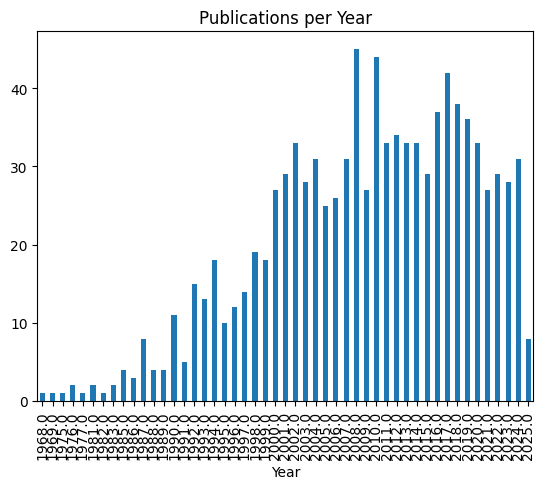

In [1601]:
import matplotlib.pyplot as plt
sem_df['Year'].value_counts().sort_index().plot(kind='bar')
plt.title("Publications per Year")

In [1602]:
# import pandas as pd

# # Load the Impact Factor dataset
# if_data = pd.read_excel("CopyofImpactFactor2024.xlsx", sheet_name="2024最新完整版IF")

# # Clean journal names and create a combined ISSN column
# if_data["CleanName"] = (
#     if_data["Name"]
#     .str.lower()
#     .str.replace(r"[^a-z0-9 ]", "", regex=True)  # Remove special characters
#     .str.strip()  # Remove leading/trailing spaces
# )
# if_data["ISSN_Combined"] = (
#     if_data["ISSN"].fillna("") + "," + if_data["EISSN"].fillna("")
# )

In [1603]:
sem_df.columns

Index(['Title', 'Abstract', 'PublicationVenueName', 'PublicationVenueType',
       'Year', 'ReferenceCount', 'CitationCount', 'InfluentialCitationCount',
       'FieldsOfStudy', 'PublicationTypes', 'PublicationDate', 'Authors',
       'DOI', 'ISSN', 'year'],
      dtype='object')

In [1604]:
len(sem_df)

1000

In [1605]:
sem_df['FieldsOfStudy'].iloc[0]

['Physics', 'Medicine']

In [1606]:
sem_df['PublicationVenueName'].iloc[777]

'Journal of Physical Chemistry A'

In [1607]:
# Top 10 influential papers
sem_df.sort_values('InfluentialCitationCount', ascending=False).head()

Title  \
774  Computation of the quantum effects d...   
73                      Open quantum systems   
598  A controlled expansion for certain n...   
179  Scale-invariant instantons and the c...   
0    Classical and quantum cosmology of t...   

                                    Abstract  \
774                                     None   
73                                      None   
598                                     None   
179  In a classically scale-invariant qua...   
0                                       None   

                        PublicationVenueName PublicationVenueType    Year  \
774                                                          None  2011.0   
73                                                           None  2004.0   
598                                                          None  2010.0   
179                                                          None  2017.0   
0    Physical Review D, Particles and fields                 None  1985.0   

    ReferenceCount  CitationCount  InfluentialCitationCount  \
774           None            569                        55   
73            None            437                        42   
598           None            204                        15   
179           None            111                        13   
0             None            317                        12   

                    FieldsOfStudy          PublicationTypes PublicationDate  \
774                          None                      None            None   
73                      [Physics]                      None      2004-11-26   
598  [Physics, Materials Science]                      None      2010-03-04   
179                     [Physics]                      None      2017-07-25   
0             [Physics, Medicine]  [JournalArticle, Review]      1985-11-15   

                                     Authors                        DOI  \
774                              G. ’t Hooft                       None   
73   A. Isar, A. Sandulescu, H. Scutaru, ...                       None   
598  David F. Mross, J. McGreevy, Hong Li...                       None   
179  Anders Andreassen, William Frost, M....                       None   
0                                A. Vilenkin  10.1103/PHYSREVD.32.2511,   

          ISSN  year  
774       None  <NA>  
73        None  2004  
598       None  2010  
179       None  2017  
0    0556-2821  1985

In [1608]:
#sem_df = sem_df[~((sem_df['PublicationVenueName'] == '') | (sem_df['FieldsOfStudy'].isnull()))]
sem_df = sem_df[~((sem_df['PublicationVenueName'] == '') | (sem_df['Year'].isnull()))]
sem_df.reset_index(drop=True, inplace=True)

In [1609]:
sem_df['FieldsOfStudy'].explode().unique()

array(['Physics', 'Medicine', 'Chemistry', 'Materials Science', None,
       'Engineering', 'Computer Science', 'Mathematics', 'Biology',
       'Geology'], dtype=object)

In [1610]:
len(sem_df)

365

In [1611]:
sem_df.isnull().sum()

Title                         0
Abstract                    285
PublicationVenueName          0
PublicationVenueType        100
Year                          0
ReferenceCount              365
CitationCount                 0
InfluentialCitationCount      0
FieldsOfStudy                58
PublicationTypes            106
PublicationDate              17
Authors                       3
DOI                         122
ISSN                        103
year                         17
dtype: int64

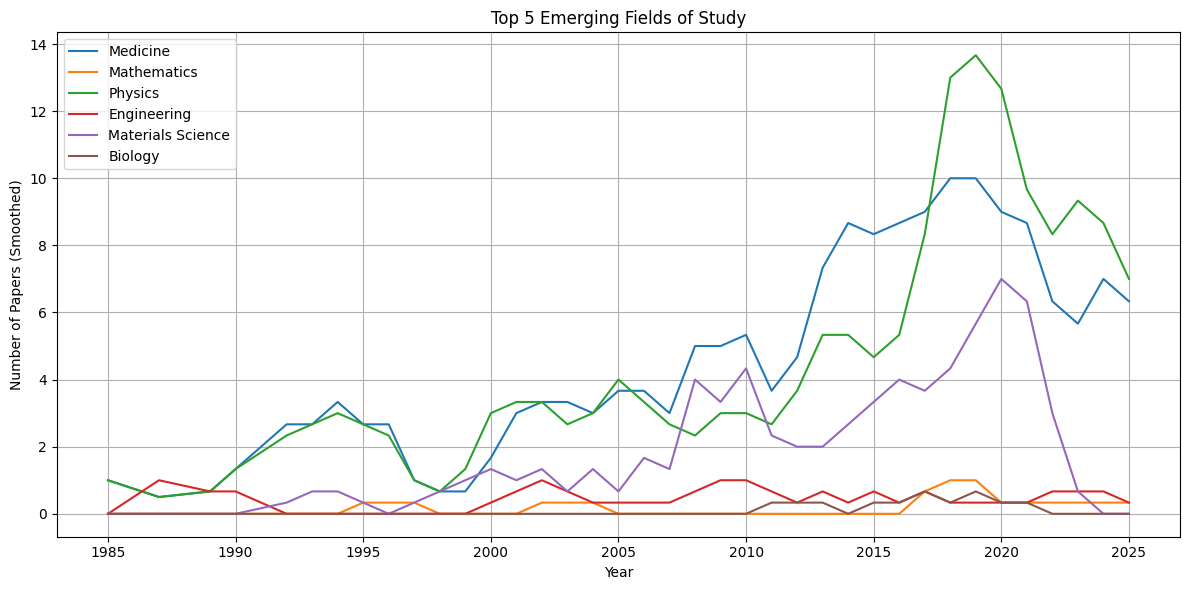

In [1612]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Explode FieldsOfStudy so each field gets its own row
df_exploded = sem_df.explode('FieldsOfStudy')

# Group by Year and Field, then count papers
field_counts = (
    df_exploded
    .groupby(['Year', 'FieldsOfStudy'])
    .size()
    .reset_index(name='PaperCount')
)

# Pivot for heatmap-style analysis or trend lines
field_pivot = field_counts.pivot(index='Year', columns='FieldsOfStudy', values='PaperCount').fillna(0)

# Optional: Smooth with rolling average (e.g., 3 years)
field_pivot_smooth = field_pivot.rolling(window=3, min_periods=1).mean()

# Plot top 5 trending fields by recent growth
recent_years = field_pivot_smooth.index[-3:]  # Last 3 years
growth = field_pivot_smooth.loc[recent_years].pct_change().mean()
top_growth_fields = growth.sort_values(ascending=False).head(6).index

# Plot trends
plt.figure(figsize=(12, 6))
for field in top_growth_fields:
    plt.plot(field_pivot_smooth.index, field_pivot_smooth[field], label=field)

plt.title('Top 5 Emerging Fields of Study')
plt.xlabel('Year')
plt.ylabel('Number of Papers (Smoothed)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


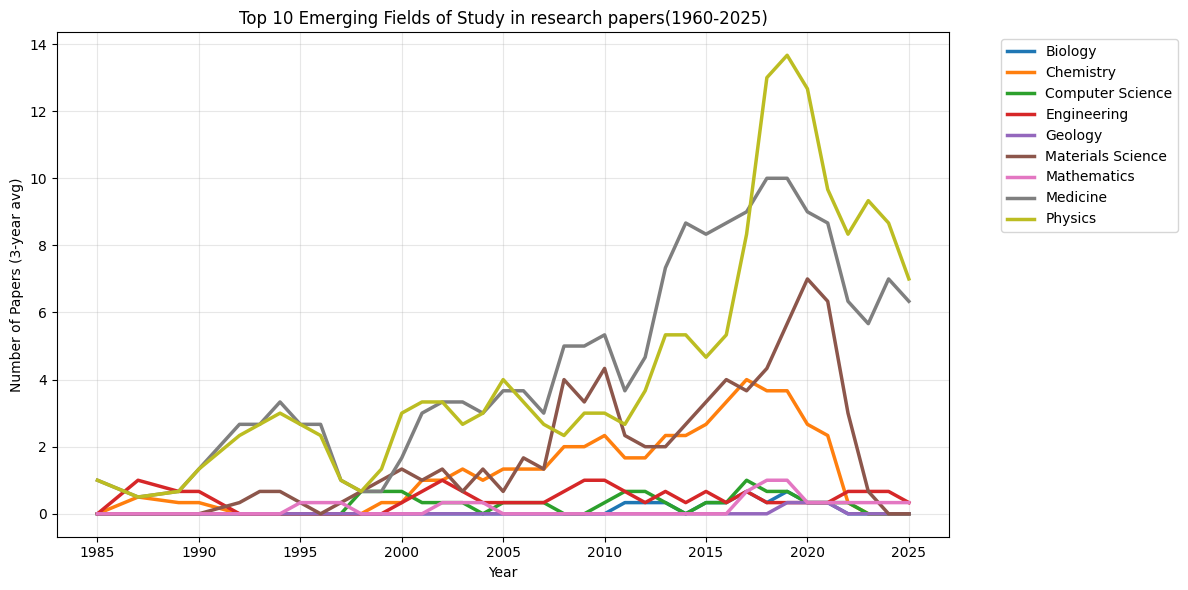

In [1613]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, IntSlider

def plot_field_trends(sem_df, start_year=None, end_year=None, window_size=3, top_n=5):
    """
    Visualize top trending fields of study with customizable year window.
    
    Args:
        sem_df (pd.DataFrame): DataFrame containing 'Year' and 'FieldsOfStudy' columns
        start_year (int): First year to display (None for auto)
        end_year (int): Last year to display (None for auto)
        window_size (int): Years for rolling average (smoothing)
        top_n (int): Number of top fields to show
    """
    # Explode fields and count papers per year/field
    df_exploded = sem_df.explode('FieldsOfStudy')
    field_counts = (
        df_exploded
        .groupby(['Year', 'FieldsOfStudy'])
        .size()
        .reset_index(name='PaperCount')
    )
    
    # Pivot and smooth with rolling average
    field_pivot = field_counts.pivot(index='Year', columns='FieldsOfStudy', values='PaperCount').fillna(0)
    field_pivot_smooth = field_pivot.rolling(window=window_size, min_periods=1).mean()
    
    # Filter by year window
    if start_year is None:
        start_year = field_pivot_smooth.index.min()
    if end_year is None:
        end_year = field_pivot_smooth.index.max()
    
    filtered = field_pivot_smooth.loc[start_year:end_year]
    
    # Calculate growth rates in the selected window
    growth = filtered.pct_change().mean()
    top_fields = growth.sort_values(ascending=False).head(top_n).index
    
    # Plotting
    plt.figure(figsize=(12, 6))
    for field in top_fields:
        plt.plot(filtered.index, filtered[field], label=field, linewidth=2.5)
    
    plt.title(f'Top {top_n} Emerging Fields of Study in research papers({start_year}-{end_year})')
    plt.xlabel('Year')
    plt.ylabel(f'Number of Papers ({window_size}-year avg)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def interactive_field_trends(sem_df):
    """Create interactive widget for exploring trends"""
    years = sem_df['Year'].dropna().astype(int).unique()
    min_year, max_year = min(years), max(years)
    
    interact(
        plot_field_trends,
        sem_df=pd.DataFrame(sem_df),  # Fixed value
        start_year=IntSlider(min=min_year, max=max_year, value=min_year, step=1, description='Start Year'),
        end_year=IntSlider(min=min_year, max=max_year, value=max_year, step=1, description='End Year'),
        window_size=IntSlider(min=1, max=5, value=3, step=1, description='Smoothing'),
        top_n=IntSlider(min=3, max=10, value=5, step=1, description='Top N Fields')
    )

# Usage:
# For static plot with custom window:
plot_field_trends(sem_df, start_year=1960, end_year=2025, window_size=3, top_n=10)

# For interactive exploration in Jupyter:
# interactive_field_trends(sem_df)

In [1614]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def plot_field_trends(sem_df, fields_to_plot=None, smoothing_window=3, figsize=(12, 6)):
    """
    Plot trends of specified fields of study over time, or top growing fields if none specified.
    
    Parameters:
    - sem_df: Input DataFrame containing 'Year' and 'FieldsOfStudy' columns
    - fields_to_plot: List of specific fields to plot (if None, plots top 5 growing fields)
    - smoothing_window: Number of years for rolling average smoothing
    - figsize: Size of the output figure
    """
    # Explode FieldsOfStudy so each field gets its own row
    df_exploded = sem_df.explode('FieldsOfStudy')
    
    # Group by Year and Field, then count papers
    field_counts = (
        df_exploded
        .groupby(['Year', 'FieldsOfStudy'])
        .size()
        .reset_index(name='PaperCount')
    )
    
    # Pivot for heatmap-style analysis or trend lines
    field_pivot = field_counts.pivot(index='Year', columns='FieldsOfStudy', values='PaperCount').fillna(0)
    
    # Smooth with rolling average
    field_pivot_smooth = field_pivot.rolling(window=smoothing_window, min_periods=1).mean()
    
    # Determine which fields to plot
    if fields_to_plot is None:
        # Calculate top growing fields if none specified
        recent_years = field_pivot_smooth.index[-3:]  # Last 3 years
        growth = field_pivot_smooth.loc[recent_years].pct_change().mean()
        fields_to_plot = growth.sort_values(ascending=False).head(5).index
        plot_title = 'Top 5 Emerging Fields of Study'
    else:
        # Use specified fields, filtering to only those available in data
        available_fields = [f for f in fields_to_plot if f in field_pivot_smooth.columns]
        if not available_fields:
            raise ValueError("None of the specified fields were found in the data")
        fields_to_plot = available_fields
        plot_title = 'Trends for Selected research Fields of Study'
    
    # Plot trends
    plt.figure(figsize=figsize)
    for field in fields_to_plot:
        plt.plot(field_pivot_smooth.index, field_pivot_smooth[field], label=field)
    
    plt.title(plot_title)
    plt.xlabel('Year')
    plt.ylabel(f'Number of Papers (Smoothed, {smoothing_window}-year avg)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
# To plot specific fields:
# plot_field_trends(sem_df, fields_to_plot=['Machine Learning', 'Neuroscience', 'Physics'])

# To plot top growing fields:
# plot_field_trends(sem_df)

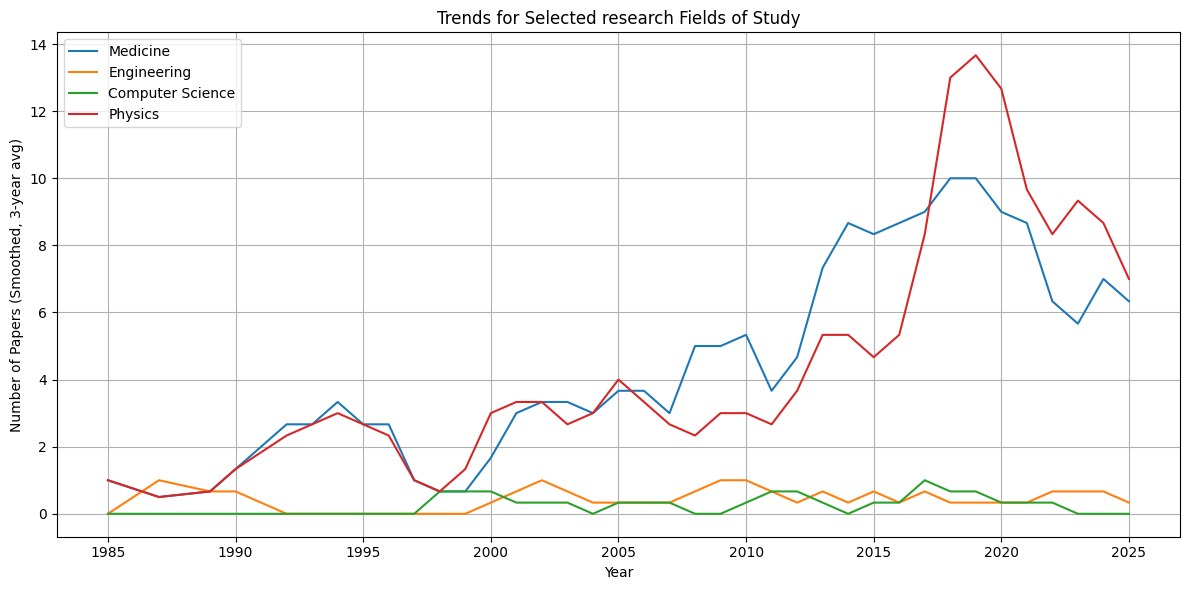

In [1615]:
plot_field_trends(sem_df, fields_to_plot=['Medicine', 'Engineering','Computer Science','Physics'])

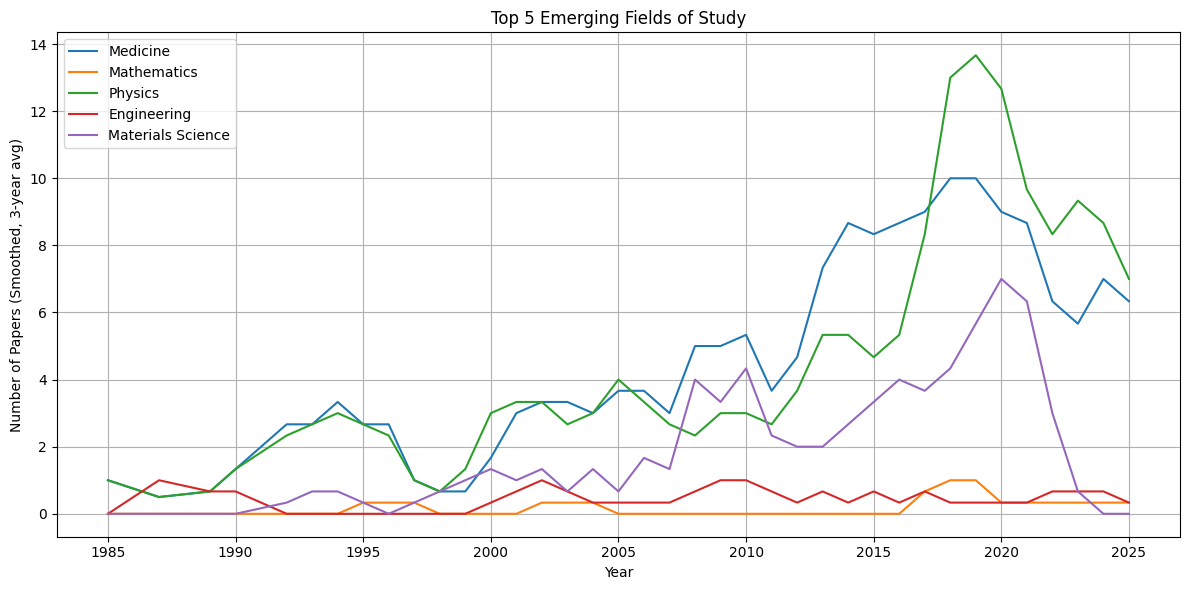

In [1616]:
plot_field_trends(sem_df)

In [1617]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
def visualize_filing_trends(df, year_col='Year', title='Paper Publication Trends'):
    """
    Creates an interactive visualization of publication trends over time,
    showing both the annual counts and the cumulative total as lines.
    """
    # Aggregate year counts
    trend_df = (
        df[year_col]
        .value_counts()
        .sort_index()
        .reset_index()
    )
    trend_df.columns = ['year', 'count']  # Rename columns explicitly
    trend_df['cumulative'] = trend_df['count'].cumsum()

    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Annual publications as a line
    fig.add_trace(
        go.Scatter(
            x=trend_df['year'],
            y=trend_df['count'],
            mode='lines+markers',
            name='Annual Publications',
            line=dict(color='#1f77b4', width=2),
            hovertemplate='Year: %{x}<br>Annual: %{y}<extra></extra>'
        ),
        secondary_y=False
    )

    # Cumulative total as a line
    fig.add_trace(
        go.Scatter(
            x=trend_df['year'],
            y=trend_df['cumulative'],
            mode='lines+markers',
            name='Cumulative Total',
            line=dict(color='#ff7f0e', width=2, dash='dash'),
            hovertemplate='Year: %{x}<br>Cumulative: %{y}<extra></extra>'
        ),
        secondary_y=True
    )

    # Update layout
    fig.update_layout(
        title_text=title,
        title_x=0.5,
        title_font_size=24,
        xaxis_title='Publication Year',
        yaxis_title='Annual Publications',
        yaxis2_title='Cumulative Publications',
        hovermode='x unified',
        template='plotly_white',
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        margin=dict(t=100),
        height=600
    )

    # Add range selector
    fig.update_xaxes(
        rangeslider_visible=True,
        dtick=2,
        rangeselector=dict(
            buttons=list([
                dict(count=5, label="5y", step="year", stepmode="backward"),
                dict(count=10, label="10y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        )
    )

    return fig, trend_df


In [1618]:
fig, trend_data = visualize_filing_trends(sem_df)
fig.show()

**keyword analysis**

In [1619]:
keyword_df = sem_df.copy()

In [1620]:
keyword_df = keyword_df.dropna(subset=['Title'])

In [1621]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

#preprocessing : lowercase and remove puctuation , remove stop words and perform stemming an lemmatization 
# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
def preprocess_text(text: str,use_stemming: bool = True) -> str:
    # Lowercase and remove punctuation
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    if use_stemming:
        tokens = [stemmer.stem(word) for word in tokens]
    else:
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

# Example usage:
keyword_df['Title'] = keyword_df['Title'].apply(preprocess_text)

keyword_df['Title'].head()


0    classic quantum cosmolog starobinski...
1    reduc dimension quantum dynam ch3 ch...
2    imag moiré excit state photocurr tun...
3    fresh look calcul tunnel action mult...
4    high sn crystallin measur effect def...
Name: Title, dtype: object

In [1622]:
from sklearn.feature_extraction.text import TfidfVectorizer


abstracts = [
    preprocess_text(abst) for abst in keyword_df['Title'].tolist()
]

vectorizer = TfidfVectorizer(max_df=0.85, min_df=2, ngram_range=(1, 3))
tfidf_matrix = vectorizer.fit_transform(abstracts) #learns the vocabulary and inverse document frequency from the abstaracts and transforms the abstracts into a TF-IDF matrix

feature_names = vectorizer.get_feature_names_out() #retrieves the feature names from the vectorizer 
print("Top 10 keywords overall:")

avg_scores = tfidf_matrix.mean(axis=0).tolist()[0]  # Compute average TF-IDF scores for each term

keywords = sorted(zip(feature_names, avg_scores), key=lambda x: x[1], reverse=True)  # Combine term with score and sort
keywords[:10]


Top 10 keywords overall:


[('quantum', 0.0665060792796194),
 ('tunnel', 0.04892691645504271),
 ('electron', 0.024136000712963436),
 ('effect', 0.02267878549994581),
 ('dot', 0.020889211432305852),
 ('quantum dot', 0.02036205172245916),
 ('magnet', 0.020028780479381548),
 ('well', 0.018565060983385034),
 ('quantum well', 0.017923174479243225),
 ('system', 0.017814586410544894)]

In [1623]:
import networkx as nx
from itertools import combinations
from collections import Counter, defaultdict

def build_cooccurrence_network(abstracts, top_keywords=None, window_size=5):
    
    G = nx.Graph()
    token_lists = [abstract.split() for abstract in abstracts]
    
    cooccurrence = defaultdict(int)
    
    for tokens in token_lists:
        # You may choose to filter tokens if top_keywords is not None:
        if top_keywords:
            tokens = [token for token in tokens if token in top_keywords]
        # Using combinations of tokens in the entire document (or use sliding window)
        # For a sliding window, you can iterate through indices.
        for token_pair in combinations(set(tokens), 2):
            cooccurrence[tuple(sorted(token_pair))] += 1
    
    # Build graph from co-occurrence dictionary
    for (w1, w2), weight in cooccurrence.items():
        if weight > 1:  # include only stronger connections if you wish
            G.add_edge(w1, w2, weight=weight)
    return G

# Build a network from your abstracts
G = build_cooccurrence_network(abstracts)
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())




Number of nodes: 307
Number of edges: 718


In [1624]:
import plotly.graph_objects as go

# Generate positions using the same NetworkX spring layout parameters
pos = nx.spring_layout(G, k=0.15, iterations=20, seed=42)  # Added seed for reproducibility

# Create edge traces with Matplotlib-like styling
edge_traces = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_traces.append(
        go.Scatter(
            x=[x0, x1, None], 
            y=[y0, y1, None],
            mode='lines',
            line=dict(width=0.3, color='rgba(50,50,50,0.3)'),  # Matches alpha=0.3
            hoverinfo='none'
        )
    )

# Create node trace with Matplotlib-like styling
node_x = []
node_y = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    marker=dict(
        showscale=False,
        color='blue',
        size=10,  # Matches Matplotlib's effective rendered size
        line=dict(width=0.5, color='DarkSlateGrey')
    ),
    hoverinfo='none'
)

# Create label annotations with Matplotlib-like styling
annotations = []
for node in G.nodes():
    x, y = pos[node]
    annotations.append(
        dict(
            x=x,
            y=y,
            xref="x",
            yref="y",
            text=node,
            showarrow=False,
            font=dict(size=8, color='black'),  # Matches font_size=8
            xanchor='center',
            yanchor='middle'
        )
    )

# Create figure with Matplotlib-like dimensions
fig = go.Figure(
    data=edge_traces + [node_trace],
    layout=go.Layout(
        title='Keyword Co-occurrence Network',
        showlegend=False,
        hovermode='closest',
        margin=dict(b=0,l=0,r=0,t=40),
        xaxis=dict(
            showgrid=False, 
            zeroline=False,
            visible=False,
            scaleanchor="y",  # Maintain aspect ratio
            scaleratio=1
        ),
        yaxis=dict(
            showgrid=False,
            zeroline=False,
            visible=False
        ),
        annotations=annotations,
        width=900,  # Matches 12" figure size at 75 DPI
        height=900,
        plot_bgcolor='white'  # Matplotlib-like white background
    )
)

fig.show()

In [1625]:
#calculate the degree centrality of nodes in tha graph 
#degree centrality is a measure of the number of direct connnections a node has 
degree_centrality = nx.degree_centrality(G)
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 keywords by degree centrality:")
print(top_degree)


Top 10 keywords by degree centrality:
[('quantum', 0.6241830065359477), ('tunnel', 0.3366013071895425), ('effect', 0.13071895424836602), ('well', 0.09477124183006536), ('magnet', 0.07189542483660132), ('dot', 0.06535947712418301), ('system', 0.06209150326797386), ('electron', 0.06209150326797386), ('reson', 0.058823529411764705), ('optic', 0.05228758169934641)]


In [1626]:
#combine abstracts by year 
grouped = keyword_df.groupby("Year")["Title"].apply(lambda texts: " ".join(texts)).reset_index()


In [1627]:
from itertools import combinations
from collections import defaultdict

def build_cooccurrence(text: str, window_size: int = 5) -> dict:
    """
    Build a co-occurrence dictionary using a sliding window.
    
    Each window of 'window_size' tokens yields co-occurring pairs.
    """
    tokens = text.split()
    cooccurrences = defaultdict(int)
    
    # Iterate over all tokens with sliding window
    for i in range(len(tokens)):
        window = tokens[i:i + window_size]
        # Generate all combinations (order doesn't matter) from the current window
        for pair in combinations(window, 2):
            # Sort the pair to keep the ordering consistent (so ('a','b') is the same as ('b','a'))
            cooccurrences[tuple(sorted(pair))] += 1
    
    return cooccurrences

# Example usage:
# Assuming 'grouped' is your DataFrame and it contains a non-empty "abstract" column.
sample_text = grouped.loc[0, "Title"]  # Replace with your actual text if needed.
cooc = build_cooccurrence(sample_text, window_size=5)
print("Co-occurrence dictionary:")
print(dict(cooc))
print("Number of edges (unique pairs):", len(cooc))


Co-occurrence dictionary:
{('classic', 'quantum'): 1, ('classic', 'cosmolog'): 1, ('classic', 'starobinski'): 1, ('classic', 'inflationari'): 1, ('cosmolog', 'quantum'): 2, ('quantum', 'starobinski'): 2, ('inflationari', 'quantum'): 2, ('cosmolog', 'starobinski'): 3, ('cosmolog', 'inflationari'): 3, ('inflationari', 'starobinski'): 4, ('model', 'quantum'): 1, ('cosmolog', 'model'): 2, ('model', 'starobinski'): 3, ('inflationari', 'model'): 4}
Number of edges (unique pairs): 14


In [1628]:
from sklearn.cluster import KMeans
import numpy as np
#identify clusters of similar documents based on the terms they contain 
# Suppose we use TF-IDF of a given time window
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(tfidf_matrix)

# Map terms to cluster centers can be done via:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
cluster_terms = {}
for i in range(num_clusters):
    cluster_terms[i] = [feature_names[ind] for ind in order_centroids[i, :10]]
    print("Cluster %d:" % i, cluster_terms[i])


Cluster 0: ['magnet', 'atom', 'electron', 'high', 'metal', 'studi', 'state', 'surfac', 'transport', 'singlemolecul']
Cluster 1: ['tunnel', 'quantum', 'quantum well', 'well', 'reson', 'quantum tunnel', 'reson tunnel', 'junction', 'diod', 'effect']
Cluster 2: ['transistor', 'perform', 'interf', 'quantum interf', 'fieldeffect', 'fieldeffect transistor', 'quantum', 'charact', 'transistor quantum', 'quantum tunnel']
Cluster 3: ['quantum', 'quantum dot', 'dot', 'system', 'doubl quantum dot', 'charg', 'effect', 'electron', 'doubl quantum', 'doubl']
Cluster 4: ['mechan', 'equat', 'quantum', 'quantum mechan', 'potenti', 'dirac', 'field', 'tunnel', 'design', 'novel']


In [1629]:
import networkx as nx
from networkx.algorithms import community
#identify groups of terms that frequently co-occur 
# Build graph from aggregated co-occurrence (for a single time window)
G = nx.Graph()
for (term1, term2), weight in cooc.items():
    if weight > 1:
        G.add_edge(term1, term2, weight=weight)

# Detect communities using a greedy modularity algorithm
communities = community.greedy_modularity_communities(G)
print("Communities:")
for idx, comm in enumerate(communities, start=1):
    print(f"Cluster {idx}:", sorted(comm))


Communities:
Cluster 1: ['cosmolog', 'inflationari', 'model', 'quantum', 'starobinski']


In [1630]:
import numpy as np
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.stats import entropy
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import defaultdict
import seaborn as sns

# ======================
# CONFIGURATION
# ======================
config = {
    'min_year': 2000,
    'min_docs_per_year': 2,       # lowered threshold for testing
    'global_min_df': 1,           # allow sparse terms for debugging
    'global_max_df': 0.9,
    'divergence_percentile': 50,
    'max_topics': 5,
    'top_words_per_topic': 10,
    'min_window_span': 1          # allow single-year windows for testing
}

# ======================
# UTILITY FUNCTIONS
# ======================
def jensen_shannon(p, q): #computes a symmetric divergence between two probability distibutions
    m = 0.5 * (p + q)
    return 0.5 * (entropy(p, m) + entropy(q, m))
#measure how different two distributions are in symmetric bounded way 
#KL(kullbac-leibler) divegence : entropy(p,m) measures how one probability distribution diverges from a second  

def safe_divide(a, b): #divides element-wise but returns 0 where the denominator is 0
    return np.divide(a, b, out=np.zeros_like(a), where=b != 0)

# ======================
# DATA PREPARATION
# ======================
keyword_df = keyword_df[keyword_df['Year'] >= config['min_year']]
keyword_df = keyword_df.sort_values('Year')

# Debug: print basic info about data
print("DataFrame shape:", keyword_df.shape)
print("Years range:", keyword_df['Year'].min(), "-", keyword_df['Year'].max())

docs = keyword_df['Title'].str.lower().str.replace(r'[^\w\s-]', '', regex=True).tolist()
years = keyword_df['Year'].astype(int).values

# ======================
# GLOBAL VOCABULARY
# ======================
global_vectorizer = CountVectorizer( #builds a single bag-of-words across all documents
    min_df=config['global_min_df'],
    max_df=config['global_max_df'],
    ngram_range=(1, 2),
    stop_words='english'
)
global_vocab = global_vectorizer.fit(docs)
print("Global vocab size:", len(global_vectorizer.vocabulary_))

# ======================
# ADAPTIVE WINDOW DETECTION
# ======================
yearly_counts = []
valid_years = []

unique_years = np.unique(years)
print("Unique years in data:", unique_years)
for year in unique_years: #for each year with more than 2 docs ,get its term-frequency vector 
    year_mask = years == year
    num_docs = sum(year_mask)
    if num_docs >= config['min_docs_per_year']:
        try:
            counts = global_vectorizer.transform(np.array(docs)[year_mask]).sum(axis=0).A1
            yearly_counts.append((year, counts))
            valid_years.append(year)
        except Exception as e:
            print(f"Skipping {year} due to error: {str(e)}")
            continue

print("Valid years detected for windowing:", valid_years)

if len(yearly_counts) < 2:
    raise ValueError(f"Only {len(yearly_counts)} valid years found. Need at least 2.")

divergences = []
for i in range(1, len(yearly_counts)): #Normalize counts into distributions and compute jensen-shannon divergence year to year
    prev = yearly_counts[i-1][1] + 1e-12 #smoothing to avoid zero probablities 
    curr = yearly_counts[i][1] + 1e-12
    prev = safe_divide(prev, prev.sum()) #for each year-vector , divide by its total word-count 
    curr = safe_divide(curr, curr.sum())
    div = jensen_shannon(prev, curr)
    divergences.append(div)

print("Calculated divergences:", divergences)
threshold = np.percentile(divergences, config['divergence_percentile']) if divergences else 0
print("Divergence threshold (", config['divergence_percentile'], "percentile):", threshold)

change_points = [0] + [i for i, d in enumerate(divergences) if d > threshold] + [len(yearly_counts)]
change_points = sorted(list(set(change_points)))
print("Change points indices:", change_points)
#any year to year jump with divergence above 85% of all the year to year divergence values marks a boundary
windows = [] #each window is a consecutive block of years between change points filtered by minimum span 
for i in range(1, len(change_points)):
    start_idx = change_points[i-1]
    end_idx = change_points[i]
    window_years = [yearly_counts[j][0] for j in range(start_idx, end_idx)]
    if not window_years:
        continue
    try:
        window_start = min(window_years)
        window_end = max(window_years)
        if (window_end - window_start) < config['min_window_span']:
            continue
    except ValueError:
        continue
    windows.append({
        'start': window_start,
        'end': window_end,
        'years': window_years
    })
    
print("Detected windows:")
for w in windows:
    print(w)

if not windows:
    raise ValueError("No valid time windows detected. Try adjusting parameters.")

# ======================
# TOPIC MODELING
# ======================
tfidf_vectorizer = TfidfVectorizer(
    vocabulary=global_vectorizer.vocabulary_,
    ngram_range=(1, 2)
)
full_matrix = tfidf_vectorizer.fit_transform(docs)
feature_names = tfidf_vectorizer.get_feature_names_out()

topic_evolution = []

for window in windows: # for each detected window choose a number of topics based on window size and fit an LDA model to extract top words per topic and save them 
    window_mask = keyword_df['Year'].isin(window['years'])
    window_matrix = full_matrix[window_mask]
    
    if window_matrix.shape[0] == 0:
        continue
        
    n_topics = max(1, min(config['max_topics'], window_matrix.shape[0] // 50))
    print(f"Window {window['start']}-{window['end']} with {window_matrix.shape[0]} docs. Using {n_topics} topics.")
    
    try:
        lda = LatentDirichletAllocation(
            n_components=n_topics,
            random_state=42,
            learning_method='online'
        )
        lda.fit(window_matrix)
        
        for topic_idx, topic in enumerate(lda.components_):
            top_indices = topic.argsort()[-config['top_words_per_topic']:][::-1]
            top_words = [feature_names[i] for i in top_indices]
            topic_evolution.append({
                'start': window['start'],
                'end': window['end'],
                'topic_id': f"{window['start']}-{topic_idx+1}",
                'words': top_words,
                'weights': topic[top_indices]
            })
            print(f"Topic {window['start']}-{topic_idx+1}: {top_words}")
    except Exception as e:
        print(f"Failed modeling {window['start']}-{window['end']}: {str(e)}")
        continue




DataFrame shape: (332, 15)
Years range: 2000.0 - 2025.0
Global vocab size: 3453
Unique years in data: [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025]
Valid years detected for windowing: [np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]
Calculated divergences: [np.float64(0.6393433808202833), np.float64(0.662399221770667), np.float64(0.6404128641337841), np.float64(0.6374200610010164), np.float64(0.6552745674298257), np.float64(0.6449638888791513), np.float64(0.6314919924276716), np.float64(0.6143409226553495), np.float64(0.5996742451645805), 

In [1631]:
import plotly.express as px
import pandas as pd

# Prepare divergence data in a DataFrame
div_df = pd.DataFrame({
    'Year': valid_years[1:],  # Divergences correspond to year changes starting from the second valid year
    'Divergence': divergences
})

# Create a line plot for term distribution divergences over years with markers
fig = px.line(div_df, x='Year', y='Divergence',
              title='Automatic Topic Shift Detection',
              markers=True)

# Add a horizontal line for the divergence threshold
fig.add_hline(y=threshold, line_dash="dash", line_color="red",
              annotation_text="Change Threshold", annotation_position="bottom right")

# Create vertical spans for each detected window using layout shapes
shapes = []
for window in windows:
    shapes.append({
        'type': 'rect',
        'xref': 'x',
        'yref': 'paper',
        'x0': window['start'],
        'x1': window['end'],
        'y0': 0,
        'y1': 1,
        'fillcolor': 'gray',
        'opacity': 0.2,
        'layer': 'below',
        'line': {'width': 0},
    })

fig.update_layout(
    shapes=shapes,
    xaxis_title='Year',
    yaxis_title='Jensen-Shannon Divergence'
)

fig.show()


In [1632]:
import pandas as pd
import plotly.express as px
#each cell in the heatmap is a raw count of how many times a given term showed up amont the top words of all topics in that window
# ----------------------
# Build the Term Matrix
# ----------------------
all_terms = list(set([word for t in topic_evolution for word in t['words']]))
term_matrix = pd.DataFrame(index=all_terms)

for window in windows:
    # Collect all terms for this window
    window_terms = [word for t in topic_evolution 
                    if t['start'] == window['start'] 
                    for word in t['words']]
    term_counts = pd.Series(window_terms).value_counts()
    term_matrix[window['start']] = term_counts

# Fill missing values and sort by window year (the DataFrame rows)
term_matrix = term_matrix.fillna(0).T.sort_index()

# Debug print: Check available columns (terms)
print("Term matrix columns:", term_matrix.columns.tolist())

# ----------------------
# Plotting with Plotly Express
# ----------------------
if not term_matrix.empty and not term_matrix.sum().nlargest(1).empty:
    # Select the top 25 terms across windows based on total counts
    top_terms = term_matrix.sum().nlargest(25).index
    selected_terms = [term for term in top_terms if term in term_matrix.columns]
    
    if selected_terms:
        # Prepare the heatmap data: subset and transpose to have Terms as rows
        heat_data = term_matrix[selected_terms].T
        
        # Create the interactive heatmap
        fig = px.imshow(heat_data,
                        text_auto=".1f",
                        color_continuous_scale='YlOrBr',
                        aspect="auto",
                        labels={"x": "Time Window Start Year", "y": "Term", "color": "Count"},
                        title="Top Terms Across Time Windows")
        fig.update_layout(title_x=0.5)
        fig.show()
    else:
        print("⚠️ No common top terms found across windows to plot heatmap.")
else:
    print("⚠️ Term matrix is empty — skipping heatmap plot.")


Term matrix columns: ['state', 'electron', 'magnet', 'scan', 'hybrid', 'conduct', 'doubl quantum', 'current', 'doubl', 'model', 'photon', 'reson', 'proton', 'quantum', 'scan tunnel', 'materi', 'transistor', 'analyt model', 'insul', 'singl', 'temperatur', 'heterostructur', 'memori', 'theori', 'tripl', 'charg', 'effect', 'dot', 'proton tunnel', 'graphen', 'dynam', 'enhanc', 'quantum dot', 'period potenti', 'junction', 'tunnel microscopi', 'tunnel', 'versatil pagerank', 'quantum tunnel', 'potenti', 'quantum physic', 'local', 'versatil']


In [1633]:
import plotly.express as px
from wordcloud import WordCloud

# 3. Evolving Word Clouds with Plotly Express
for window in windows:
    # Collect terms for the current window
    terms = [word for t in topic_evolution 
             if t['start'] == window['start'] 
             for word in t['words']]
    
    if not terms:
        continue
    
    # Generate the word cloud image using the WordCloud library
    wordcloud = WordCloud(width=1200, height=800, 
                          background_color='white',
                          colormap='tab10').generate(' '.join(terms))
    
    # Convert the word cloud to a NumPy array (RGB image)
    wc_array = wordcloud.to_array()
    
    # Use Plotly Express to display the word cloud image interactively
    fig = px.imshow(wc_array)
    fig.update_layout(
        title_text=f"{window['start']}-{window['end']} Key Concepts",
        title_x=0.5,
        xaxis={'visible': False},
        yaxis={'visible': False}
    )
    fig.show()


In [1634]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def visualize_filing_trends(df, year_col='Year', title='Publication Trends'):
    """
    Creates an interactive visualization of publication trends over time.
    
    Args:
        df (pd.DataFrame): DataFrame containing year column
        year_col (str): Name of column containing publication years
        title (str): Chart title
        
    Returns:
        tuple: (fig, trend_df) Plotly figure and aggregated trend data
    """
    # Create aggregated data
    trend_df = df[year_col].value_counts().sort_index().reset_index()
    trend_df.columns = ['year', 'count']
    trend_df['cumulative'] = trend_df['count'].cumsum()
    
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    # Add bar chart for annual counts
    fig.add_trace(
        go.Bar(
            x=trend_df['year'],
            y=trend_df['count'],
            name='Annual Publications',
            marker_color='#1f77b4',
            hovertemplate='Year: %{x}<br>Annual: %{y}<extra></extra>'
        ),
        secondary_y=False
    )
    
    # Add line chart for cumulative trend
    fig.add_trace(
        go.Scatter(
            x=trend_df['year'],
            y=trend_df['cumulative'],
            name='Cumulative Total',
            line=dict(color='#ff7f0e', width=3),
            hovertemplate='Year: %{x}<br>Cumulative: %{y}<extra></extra>'
        ),
        secondary_y=True
    )
    
    # Update layout
    fig.update_layout(
        title_text=title,
        title_x=0.5,
        title_font_size=24,
        xaxis_title='Publication Year',
        yaxis_title='Annual Publications',
        yaxis2_title='Cumulative Publications',
        hovermode='x unified',
        template='plotly_white',
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        margin=dict(t=100),
        height=600
    )
    
    # Add range selector
    fig.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
            buttons=list([
                dict(count=5, label="5y", step="year", stepmode="backward"),
                dict(count=10, label="10y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        )
    )
    
    return fig, trend_df

# Usage example:
# fig, trend_data = visualize_filing_trends(df_with_years)
# fig.show()

In [1635]:
#semantic scolar
fig, trend_data = visualize_filing_trends(sem_df)
fig.show()

In [1636]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def visualize_filing_trends(df, year_col='Year', title='Patent Publication Trends'):
    """
    Creates an interactive visualization of publication trends over time,
    showing both the annual counts and the cumulative total as lines.
    """
    # Create aggregated data
    trend_df = (
        df[year_col]
        .value_counts()
        .sort_index()
        .reset_index()
        .rename(columns={'index': 'year', year_col: 'count'})
    )
    trend_df['cumulative'] = trend_df['count'].cumsum()

    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Annual publications as a line
    fig.add_trace(
        go.Scatter(
            x=trend_df['year'],
            y=trend_df['count'],
            mode='lines+markers',
            name='Annual Publications',
            line=dict(color='#1f77b4', width=2),
            hovertemplate='Year: %{x}<br>Annual: %{y}<extra></extra>'
        ),
        secondary_y=False
    )

    # Cumulative total as a line
    fig.add_trace(
        go.Scatter(
            x=trend_df['year'],
            y=trend_df['cumulative'],
            mode='lines+markers',
            name='Cumulative Total',
            line=dict(color='#ff7f0e', width=2, dash='dash'),
            hovertemplate='Year: %{x}<br>Cumulative: %{y}<extra></extra>'
        ),
        secondary_y=True
    )

    # Update layout
    fig.update_layout(
        title_text=title,
        title_x=0.5,
        title_font_size=24,
        xaxis_title='Publication Year',
        yaxis_title='Annual Publications',
        yaxis2_title='Cumulative Publications',
        hovermode='x unified',
        template='plotly_white',
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        margin=dict(t=100),
        height=600
    )

    # Add range selector
    fig.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
            buttons=list([
                dict(count=5, label="5y", step="year", stepmode="backward"),
                dict(count=10, label="10y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        )
    )

    return fig, trend_df

# Usage:
# fig, trend_data = visualize_filing_trends(df_with_years)
# fig.show()


In [1637]:
sem_df.head(1)

Title Abstract  \
0  Classical and quantum cosmology of t...     None   

                      PublicationVenueName PublicationVenueType    Year  \
0  Physical Review D, Particles and fields                 None  1985.0   

  ReferenceCount  CitationCount  InfluentialCitationCount  \
0           None            317                        12   

         FieldsOfStudy          PublicationTypes PublicationDate      Authors  \
0  [Physics, Medicine]  [JournalArticle, Review]      1985-11-15  A. Vilenkin   

                         DOI       ISSN  year  
0  10.1103/PHYSREVD.32.2511,  0556-2821  1985

In [1638]:
sem_df.columns

Index(['Title', 'Abstract', 'PublicationVenueName', 'PublicationVenueType',
       'Year', 'ReferenceCount', 'CitationCount', 'InfluentialCitationCount',
       'FieldsOfStudy', 'PublicationTypes', 'PublicationDate', 'Authors',
       'DOI', 'ISSN', 'year'],
      dtype='object')

**impact factor**

In [1639]:
if_data = pd.read_excel("CopyofImpactFactor2024.xlsx", sheet_name="2024最新完整版IF")

In [1640]:
if_data.columns

Index(['Name', 'Abbr Name', 'ISSN', 'EISSN', 'JIF', 'JIF5Years', 'Category'], dtype='object')

In [1641]:
if_data.head()

Name            Abbr Name       ISSN  \
0  CA-A CANCER JOURNAL FOR CLINICIANS     CA-CANCER J CLIN  0007-9235   
1       NATURE REVIEWS DRUG DISCOVERY  NAT REV DRUG DISCOV  1474-1776   
2                              LANCET               LANCET  0140-6736   
3     NEW ENGLAND JOURNAL OF MEDICINE       NEW ENGL J MED  0028-4793   
4         BMJ-British Medical Journal       BMJ-BRIT MED J  0959-535X   

       EISSN    JIF JIF5Years                               Category  
0  1542-4863  503.1     297.0                      ONCOLOGY|Q1|1/322  
1  1474-1784  122.7     114.9       PHARMACOLOGY & PHARMACY|Q1|1/354  
2  1474-547X   98.4     106.9  MEDICINE, GENERAL & INTERNAL|Q1|1/325  
3  1533-4406   96.2      94.3  MEDICINE, GENERAL & INTERNAL|Q1|2/325  
4  1756-1833   93.6      69.9  MEDICINE, GENERAL & INTERNAL|Q1|3/325

In [1642]:
if 'Category' in if_data.columns:
  unique_categories = if_data['Category'].unique()
  print(unique_categories)
else:
  print("The 'Category' column does not exist in the dataset.")

['ONCOLOGY|Q1|1/322' 'PHARMACOLOGY & PHARMACY|Q1|1/354'
 'MEDICINE, GENERAL & INTERNAL|Q1|1/325' ...
 'DEVELOPMENT STUDIES|Q3|39/63' 'GERONTOLOGY|Q3|27/47'
 'PHYSICS, MULTIDISCIPLINARY|Q2|54/110']


In [1643]:
# Parse and clean the unique categories
cleaned_categories = set()
for category in unique_categories:
  # Split by '|' and '&', and take the first part
  cleaned = category.split('|')[0].strip()
  cleaned_categories.add(cleaned)

# Convert the set to a sorted list of unique keywords
unique_keywords = sorted(cleaned_categories)
print(unique_keywords)

['ACOUSTICS', 'AGRICULTURAL ECONOMICS & POLICY', 'AGRICULTURAL ENGINEERING', 'AGRICULTURE, DAIRY & ANIMAL SCIENCE', 'AGRICULTURE, MULTIDISCIPLINARY', 'AGRONOMY', 'ALLERGY', 'ANATOMY & MORPHOLOGY', 'ANDROLOGY', 'ANESTHESIOLOGY', 'ANTHROPOLOGY', 'ARCHAEOLOGY', 'ARCHITECTURE', 'AREA STUDIES', 'ART', 'ASIAN STUDIES', 'ASTRONOMY & ASTROPHYSICS', 'AUDIOLOGY & SPEECH-LANGUAGE PATHOLOGY', 'AUTOMATION & CONTROL SYSTEMS', 'BEHAVIORAL SCIENCES', 'BIOCHEMICAL RESEARCH METHODS', 'BIOCHEMISTRY & MOLECULAR BIOLOGY', 'BIODIVERSITY CONSERVATION', 'BIOLOGY', 'BIOPHYSICS', 'BIOTECHNOLOGY & APPLIED MICROBIOLOGY', 'BUSINESS', 'BUSINESS, FINANCE', 'CARDIAC & CARDIOVASCULAR SYSTEMS', 'CELL & TISSUE ENGINEERING', 'CELL BIOLOGY', 'CHEMISTRY, ANALYTICAL', 'CHEMISTRY, APPLIED', 'CHEMISTRY, INORGANIC & NUCLEAR', 'CHEMISTRY, MEDICINAL', 'CHEMISTRY, MULTIDISCIPLINARY', 'CHEMISTRY, ORGANIC', 'CHEMISTRY, PHYSICAL', 'CLASSICS', 'CLINICAL NEUROLOGY', 'COMMUNICATION', 'COMPUTER SCIENCE, ARTIFICIAL INTELLIGENCE', 'COMPUT

In [1644]:
len(unique_keywords)

254

In [1645]:
# Parse and clean the 'Category' column
if_data['CleanedCategory'] = if_data['Category'].apply(lambda x: x.split('|')[0].strip() if isinstance(x, str) else None)

# Display the first few rows of the updated DataFrame
if_data[['Category', 'CleanedCategory']].head()

Category               CleanedCategory
0                      ONCOLOGY|Q1|1/322                      ONCOLOGY
1       PHARMACOLOGY & PHARMACY|Q1|1/354       PHARMACOLOGY & PHARMACY
2  MEDICINE, GENERAL & INTERNAL|Q1|1/325  MEDICINE, GENERAL & INTERNAL
3  MEDICINE, GENERAL & INTERNAL|Q1|2/325  MEDICINE, GENERAL & INTERNAL
4  MEDICINE, GENERAL & INTERNAL|Q1|3/325  MEDICINE, GENERAL & INTERNAL

In [1646]:
if_data = if_data.drop(columns=['Category']).rename(columns={'CleanedCategory': 'subcategory'})

In [1647]:
# Drop rows where any field is NaN
journal_subcategories_to_categories = pd.read_csv('journal_subcategories_to_categories.csv')
journal_subcategories_to_categories = journal_subcategories_to_categories.dropna()

# Remove the first line that duplicates the headers
journal_subcategories_to_categories = journal_subcategories_to_categories.iloc[1:]

journal_subcategories_to_categories.head(10)

Discipline                  Field
1                            ACOUSTICS                Physics
2      AGRICULTURAL ECONOMICS & POLICY  Environmental Science
3             AGRICULTURAL ENGINEERING            Engineering
4   AGRICULTURE DAIRY & ANIMAL SCIENCE                Biology
5        AGRICULTURE MULTIDISCIPLINARY                Biology
6                             AGRONOMY                Biology
7                              ALLERGY               Medicine
8                 ANATOMY & MORPHOLOGY                Biology
9                            ANDROLOGY               Medicine
10                      ANESTHESIOLOGY               Medicine

In [1648]:
# Convert both to sets
keyword_set = set(unique_keywords)
discipline_set = set(journal_subcategories_to_categories['Discipline'].dropna().unique())  # Handle NaN values

# Find missing keywords
missing_keywords = keyword_set - discipline_set

if not missing_keywords:
    print("All keywords exist in the discipline column!")
else:
    print(f"{len(missing_keywords)} keywords are missing from discipline column:")
    print(missing_keywords)

81 keywords are missing from discipline column:
{'PUBLIC, ENVIRONMENTAL & OCCUPATIONAL HEALTH', 'PSYCHOLOGY, CLINICAL', 'ENGINEERING, ELECTRICAL & ELECTRONIC', 'COMPUTER SCIENCE, THEORY & METHODS', 'AGRICULTURE, DAIRY & ANIMAL SCIENCE', 'CHEMISTRY, MEDICINAL', 'PHYSICS, NUCLEAR', 'MATERIALS SCIENCE, PAPER & WOOD', 'CHEMISTRY, MULTIDISCIPLINARY', 'CHEMISTRY, INORGANIC & NUCLEAR', 'COMPUTER SCIENCE, INFORMATION SYSTEMS', 'ENGINEERING, ENVIRONMENTAL', 'ENGINEERING, BIOMEDICAL', 'PSYCHOLOGY, BIOLOGICAL', 'COMPUTER SCIENCE, HARDWARE & ARCHITECTURE', 'PSYCHOLOGY, MATHEMATICAL', 'COMPUTER SCIENCE, SOFTWARE ENGINEERING', 'PHYSICS, PARTICLES & FIELDS', 'LITERATURE, BRITISH ISLES', 'EDUCATION, SCIENTIFIC DISCIPLINES', 'LITERATURE, ROMANCE', 'PHYSICS, CONDENSED MATTER', 'ENGINEERING, MARINE', 'FILM, RADIO, TELEVISION', 'ENGINEERING, MULTIDISCIPLINARY', 'COMPUTER SCIENCE, CYBERNETICS', 'ENGINEERING, MECHANICAL', 'HUMANITIES, MULTIDISCIPLINARY', 'PSYCHOLOGY, EXPERIMENTAL', 'PHYSICS, ATOMIC, MOLECUL

In [1649]:
len(if_data['subcategory'])

21800

In [1650]:
journal_subcategories_to_categories[['Discipline','Field']].isnull().sum()

Discipline    0
Field         0
dtype: int64

In [1651]:
len(journal_subcategories_to_categories[['Discipline','Field']])

254

In [1652]:
# Drop rows where any field is NaN
journal_subcategories_to_categories = pd.read_csv('journal_subcategories_to_categories.csv')
journal_subcategories_to_categories = journal_subcategories_to_categories.dropna()

# Remove the first line that duplicates the headers
journal_subcategories_to_categories = journal_subcategories_to_categories.iloc[1:]

journal_subcategories_to_categories.head(10)

Discipline                  Field
1                            ACOUSTICS                Physics
2      AGRICULTURAL ECONOMICS & POLICY  Environmental Science
3             AGRICULTURAL ENGINEERING            Engineering
4   AGRICULTURE DAIRY & ANIMAL SCIENCE                Biology
5        AGRICULTURE MULTIDISCIPLINARY                Biology
6                             AGRONOMY                Biology
7                              ALLERGY               Medicine
8                 ANATOMY & MORPHOLOGY                Biology
9                            ANDROLOGY               Medicine
10                      ANESTHESIOLOGY               Medicine

In [1653]:
missing_to_field = {
    'ENGINEERING, ELECTRICAL & ELECTRONIC': 'Engineering',
    'PHYSICS, APPLIED': 'Physics',
    'MATERIALS SCIENCE, PAPER & WOOD': 'Materials Science',
    'PSYCHOLOGY, PSYCHOANALYSIS': 'Medicine',
    'ENGINEERING, BIOMEDICAL': 'Engineering',
    'COMPUTER SCIENCE, INTERDISCIPLINARY APPLICATIONS': 'Computer Science',
    'CHEMISTRY, MULTIDISCIPLINARY': 'Chemistry',
    'CHEMISTRY, PHYSICAL': 'Chemistry',
    'CHEMISTRY, ANALYTICAL': 'Chemistry',
    'MATHEMATICS, INTERDISCIPLINARY APPLICATIONS': 'Mathematics',
    'RADIOLOGY, NUCLEAR MEDICINE & MEDICAL IMAGING': 'Medicine',
    'PHYSICS, MULTIDISCIPLINARY': 'Physics',
    'FILM, RADIO, TELEVISION': 'Computer Science',
    'ENGINEERING, PETROLEUM': 'Engineering',
    'ENGINEERING, MARINE': 'Engineering',
    'ENGINEERING, CHEMICAL': 'Engineering',
    'PSYCHOLOGY, CLINICAL': 'Medicine',
    'PSYCHOLOGY, APPLIED': 'Medicine',
    'LITERATURE, SLAVIC': 'Environmental Science',
    'AGRICULTURE, DAIRY & ANIMAL SCIENCE': 'Biology',
    'ENGINEERING, ENVIRONMENTAL': 'Engineering',
    'MATERIALS SCIENCE, BIOMATERIALS': 'Materials Science',
    'LITERATURE, AFRICAN, AUSTRALIAN, CANADIAN': 'Environmental Science',
    'PSYCHOLOGY, EXPERIMENTAL': 'Medicine',
    'PSYCHOLOGY, EDUCATIONAL': 'Medicine',
    'EDUCATION, SPECIAL': 'Medicine',
    'MATERIALS SCIENCE, COATINGS & FILMS': 'Materials Science',
    'MATERIALS SCIENCE, MULTIDISCIPLINARY': 'Materials Science',
    'COMPUTER SCIENCE, HARDWARE & ARCHITECTURE': 'Computer Science',
    'PHYSICS, FLUIDS & PLASMAS': 'Physics',
    'SOCIAL SCIENCES, INTERDISCIPLINARY': 'Mathematics',
    'PSYCHOLOGY, MULTIDISCIPLINARY': 'Medicine',
    'ENGINEERING, GEOLOGICAL': 'Engineering',
    'GEOGRAPHY, PHYSICAL': 'Geology',
    'MATHEMATICS, APPLIED': 'Mathematics',
    'PSYCHOLOGY, DEVELOPMENTAL': 'Medicine',
    'PHYSICS, CONDENSED MATTER': 'Physics',
    'ENGINEERING, MANUFACTURING': 'Engineering',
    'MEDICINE, RESEARCH & EXPERIMENTAL': 'Medicine',
    'ENGINEERING, OCEAN': 'Engineering',
    'ENGINEERING, AEROSPACE': 'Engineering',
    'COMPUTER SCIENCE, SOFTWARE ENGINEERING': 'Computer Science',
    'PHYSICS, PARTICLES & FIELDS': 'Physics',
    'PSYCHOLOGY, MATHEMATICAL': 'Mathematics',
    'PUBLIC, ENVIRONMENTAL & OCCUPATIONAL HEALTH': 'Medicine',
    'EDUCATION, SCIENTIFIC DISCIPLINES': 'Mathematics',
    'PHYSICS, MATHEMATICAL': 'Physics',
    'HOSPITALITY, LEISURE, SPORT & TOURISM': 'Environmental Science',
    'GEOSCIENCES, MULTIDISCIPLINARY': 'Geology',
    'ENGINEERING, INDUSTRIAL': 'Engineering',
    'MATERIALS SCIENCE, CHARACTERIZATION & TESTING': 'Materials Science',
    'CHEMISTRY, ORGANIC': 'Chemistry',
    'DENTISTRY, ORAL SURGERY & MEDICINE': 'Medicine',
    'MEDICINE, GENERAL & INTERNAL': 'Medicine',
    'COMPUTER SCIENCE, INFORMATION SYSTEMS': 'Computer Science',
    'COMPUTER SCIENCE, THEORY & METHODS': 'Computer Science',
    'LITERATURE, BRITISH ISLES': 'Environmental Science',
    'PHYSICS, NUCLEAR': 'Physics',
    'MEDICINE, LEGAL': 'Medicine',
    'PHYSICS, ATOMIC, MOLECULAR & CHEMICAL': 'Physics',
    'LITERATURE, GERMAN, DUTCH, SCANDINAVIAN': 'Environmental Science',
    'SOCIAL SCIENCES, MATHEMATICAL METHODS': 'Mathematics',
    'CHEMISTRY, APPLIED': 'Chemistry',
    'HUMANITIES, MULTIDISCIPLINARY': 'Environmental Science',
    'SOCIAL SCIENCES, BIOMEDICAL': 'Medicine',
    'LITERATURE, AMERICAN': 'Environmental Science',
    'BUSINESS, FINANCE': 'Mathematics',
    'LITERATURE, ROMANCE': 'Environmental Science',
    'CHEMISTRY, INORGANIC & NUCLEAR': 'Chemistry',
    'CHEMISTRY, MEDICINAL': 'Chemistry',
    'PSYCHOLOGY, SOCIAL': 'Medicine',
    'MATERIALS SCIENCE, CERAMICS': 'Materials Science',
    'MATERIALS SCIENCE, COMPOSITES': 'Materials Science',
    'COMPUTER SCIENCE, ARTIFICIAL INTELLIGENCE': 'Computer Science',
    'PSYCHOLOGY, BIOLOGICAL': 'Medicine',
    'COMPUTER SCIENCE, CYBERNETICS': 'Computer Science',
    'MATERIALS SCIENCE, TEXTILES': 'Materials Science',
    'ENGINEERING, CIVIL': 'Engineering',
    'ENGINEERING, MULTIDISCIPLINARY': 'Engineering',
    'AGRICULTURE, MULTIDISCIPLINARY': 'Biology',
    'ENGINEERING, MECHANICAL': 'Engineering'
}



In [1654]:
new_rows = (
    pd.DataFrame.from_dict(
        missing_to_field, orient='index', columns=['Field']
    )
    .reset_index()
    .rename(columns={'index': 'Discipline'})
)

# 4. concat the two DataFrames
df_journals_complete  = pd.concat([journal_subcategories_to_categories, new_rows], ignore_index=True)

# 5. (optional) if you want to guard against accidentally duplicating any Discipline:
df_journals_complete = df_journals_complete.drop_duplicates(subset=['Discipline'], keep='first')

In [1655]:
# Convert both to sets
keyword_set = set(unique_keywords)
discipline_set = set(df_journals_complete['Discipline'].dropna().unique())  # Handle NaN values

# Find missing keywords
missing_keywords = keyword_set - discipline_set

if not missing_keywords:
    print("All keywords exist in the discipline column!")
else:
    print(f"{len(missing_keywords)} keywords are missing from discipline column:")
    print(missing_keywords)

All keywords exist in the discipline column!


In [1656]:
# First, verify the mapping compatibility
# Get unique counts from both columns
print("Unique disciplines in mapping:", df_journals_complete['Discipline'].nunique())
print("Unique subcategories in journals:", if_data['subcategory'].nunique())

# Check for missing mappings
missing_subcats = set(if_data['subcategory']) - set(df_journals_complete['Discipline'])
print(f"\nNumber of subcategories without mapping: {len(missing_subcats)}")

# Perform the merge using different column names
merged_data = pd.merge(
    if_data,
    df_journals_complete,
    left_on='subcategory',
    right_on='Discipline',
    how='left'  # Keep all journals even if no match found
)

# For journals without matching discipline, we could fill with 'Unknown'
merged_data['Field'] = merged_data['Field'].fillna('Unknown')

# Verify results
print("\nMerge results:")
print(f"Total journals: {len(merged_data)}")
print(f"Assigned fields distribution:\n{merged_data['Field'].value_counts(dropna=False)}")

# Check for potential duplicates in mapping
if journal_subcategories_to_categories['Discipline'].duplicated().any():
    print("\nWarning: Duplicate disciplines in mapping dataframe - ensure this is intentional")

Unique disciplines in mapping: 335
Unique subcategories in journals: 254

Number of subcategories without mapping: 0

Merge results:
Total journals: 21800
Assigned fields distribution:
Field
Medicine                 6086
Mathematics              4947
Environmental Science    3305
Biology                  2029
Engineering              1435
Computer Science         1273
Physics                   940
Materials Science         654
Chemistry                 597
Geology                   534
Name: count, dtype: int64


In [1657]:
merged_data.head(10)

Name             Abbr Name       ISSN  \
0     CA-A CANCER JOURNAL FOR CLINICIANS      CA-CANCER J CLIN  0007-9235   
1          NATURE REVIEWS DRUG DISCOVERY   NAT REV DRUG DISCOV  1474-1776   
2                                 LANCET                LANCET  0140-6736   
3        NEW ENGLAND JOURNAL OF MEDICINE        NEW ENGL J MED  0028-4793   
4            BMJ-British Medical Journal        BMJ-BRIT MED J  0959-535X   
5  NATURE REVIEWS MOLECULAR CELL BIOLOGY  NAT REV MOL CELL BIO  1471-0072   
6       Nature Reviews Clinical Oncology    NAT REV CLIN ONCOL  1759-4774   
7               Nature Reviews Materials         NAT REV MATER  2058-8437   
8         Nature Reviews Disease Primers   NAT REV DIS PRIMERS  2056-676X   
9                  NATURE REVIEWS CANCER        NAT REV CANCER  1474-175X   

       EISSN    JIF JIF5Years                   subcategory  \
0  1542-4863  503.1     297.0                      ONCOLOGY   
1  1474-1784  122.7     114.9       PHARMACOLOGY & PHARMACY   
2  1474-547X   98.4     106.9  MEDICINE, GENERAL & INTERNAL   
3  1533-4406   96.2      94.3  MEDICINE, GENERAL & INTERNAL   
4  1756-1833   93.6      69.9  MEDICINE, GENERAL & INTERNAL   
5  1471-0080   81.3     115.5                  CELL BIOLOGY   
6  1759-4782   81.1      81.5                      ONCOLOGY   
7  2058-8437   79.8      85.7  NANOSCIENCE & NANOTECHNOLOGY   
8  2056-676X   76.9      92.6  MEDICINE, GENERAL & INTERNAL   
9  1474-1768   72.5      77.2                      ONCOLOGY   

                     Discipline              Field  
0                      ONCOLOGY           Medicine  
1       PHARMACOLOGY & PHARMACY           Medicine  
2  MEDICINE, GENERAL & INTERNAL           Medicine  
3  MEDICINE, GENERAL & INTERNAL           Medicine  
4  MEDICINE, GENERAL & INTERNAL           Medicine  
5                  CELL BIOLOGY            Biology  
6                      ONCOLOGY           Medicine  
7  NANOSCIENCE & NANOTECHNOLOGY  Materials Science  
8  MEDICINE, GENERAL & INTERNAL           Medicine  
9                      ONCOLOGY           Medicine

In [1658]:
# Option 1: Keep all columns
final_data = merged_data

# Option 2: Select specific columns
final_data = merged_data[['Name','Abbr Name','ISSN', 'subcategory', 'Field','JIF5Years']]

In [1659]:
final_data.head()

Name            Abbr Name       ISSN  \
0  CA-A CANCER JOURNAL FOR CLINICIANS     CA-CANCER J CLIN  0007-9235   
1       NATURE REVIEWS DRUG DISCOVERY  NAT REV DRUG DISCOV  1474-1776   
2                              LANCET               LANCET  0140-6736   
3     NEW ENGLAND JOURNAL OF MEDICINE       NEW ENGL J MED  0028-4793   
4         BMJ-British Medical Journal       BMJ-BRIT MED J  0959-535X   

                    subcategory     Field JIF5Years  
0                      ONCOLOGY  Medicine     297.0  
1       PHARMACOLOGY & PHARMACY  Medicine     114.9  
2  MEDICINE, GENERAL & INTERNAL  Medicine     106.9  
3  MEDICINE, GENERAL & INTERNAL  Medicine      94.3  
4  MEDICINE, GENERAL & INTERNAL  Medicine      69.9

Plotting for Field: Medicine


C:\Users\tasni\AppData\Local\Temp\ipykernel_36368\4209112351.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



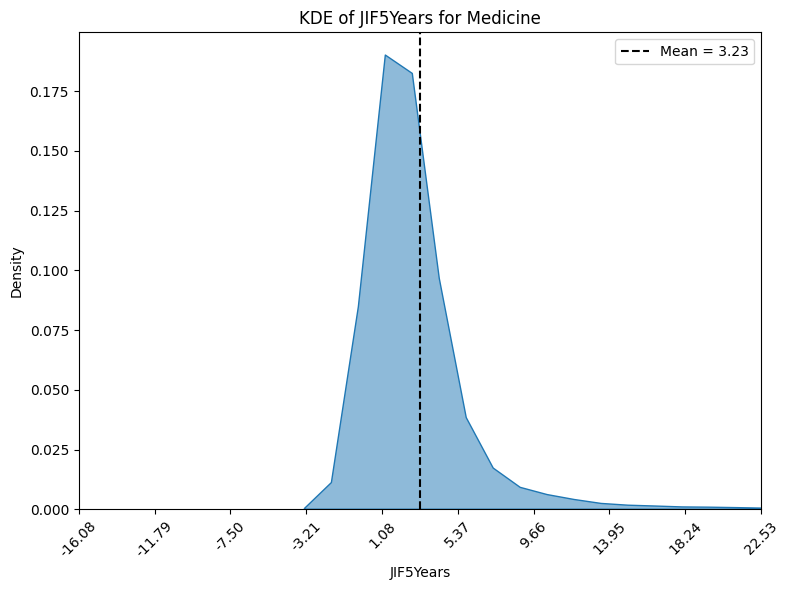

C:\Users\tasni\AppData\Local\Temp\ipykernel_36368\4209112351.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Plotting for Field: Biology


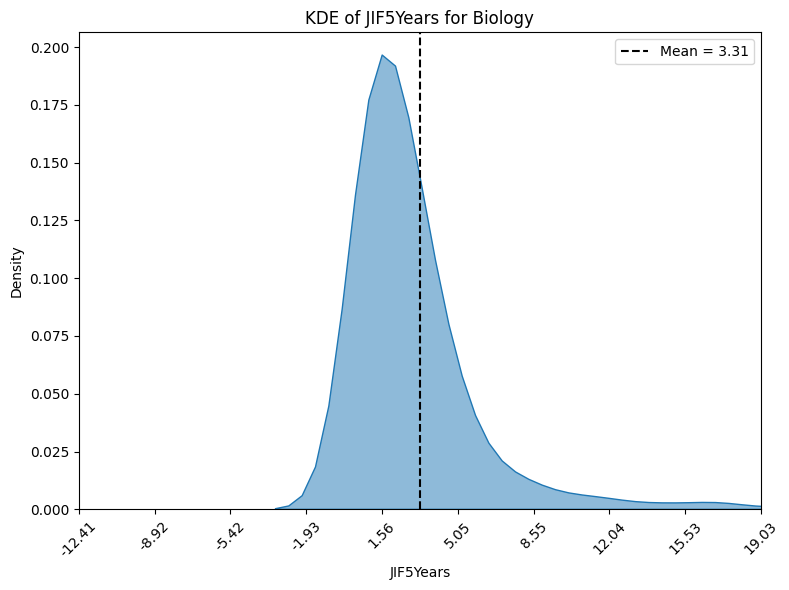

Plotting for Field: Materials Science


C:\Users\tasni\AppData\Local\Temp\ipykernel_36368\4209112351.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



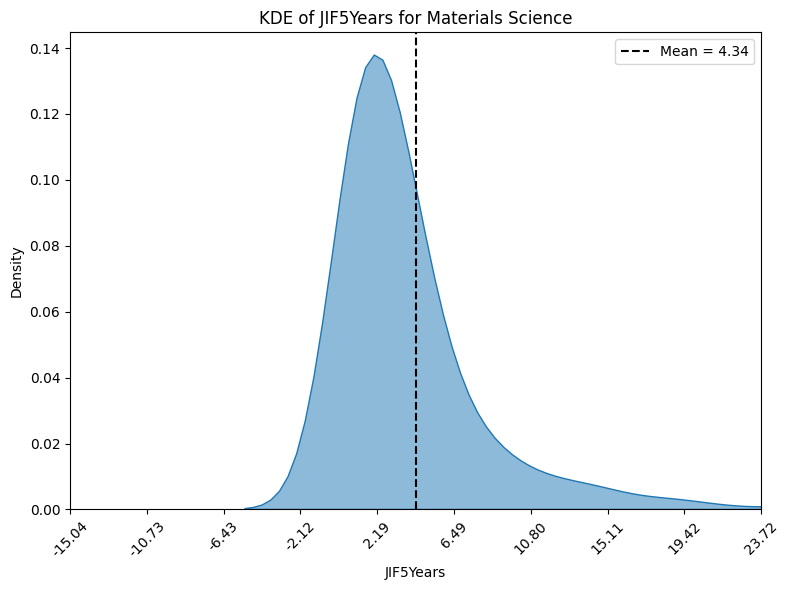

Plotting for Field: Computer Science


C:\Users\tasni\AppData\Local\Temp\ipykernel_36368\4209112351.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



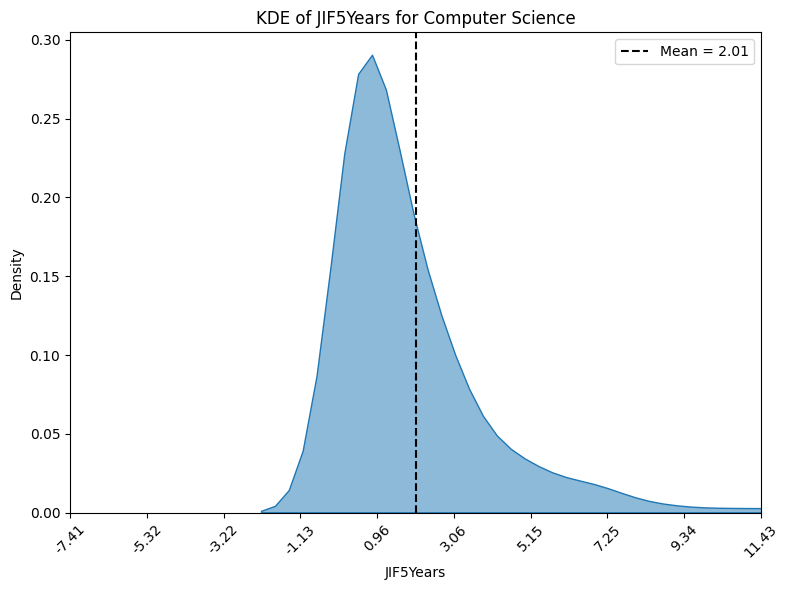

Plotting for Field: Chemistry


C:\Users\tasni\AppData\Local\Temp\ipykernel_36368\4209112351.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



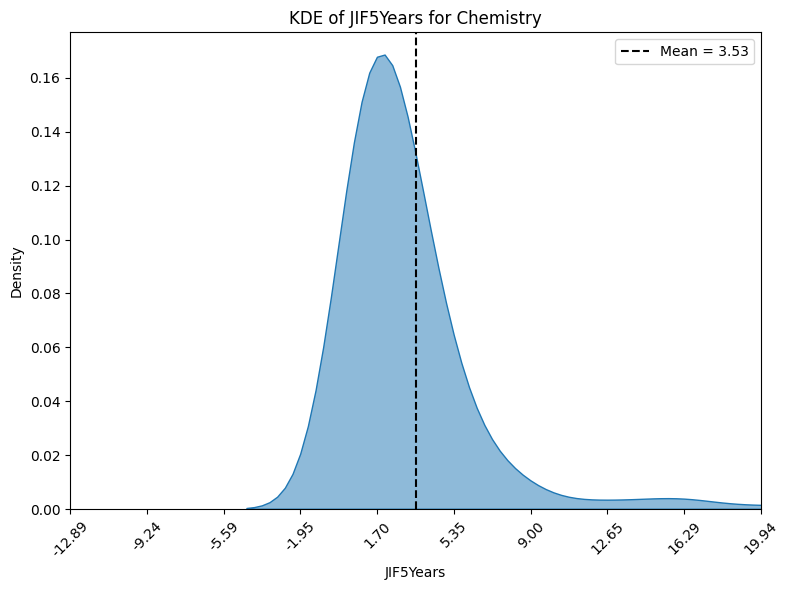

Plotting for Field: Mathematics


C:\Users\tasni\AppData\Local\Temp\ipykernel_36368\4209112351.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



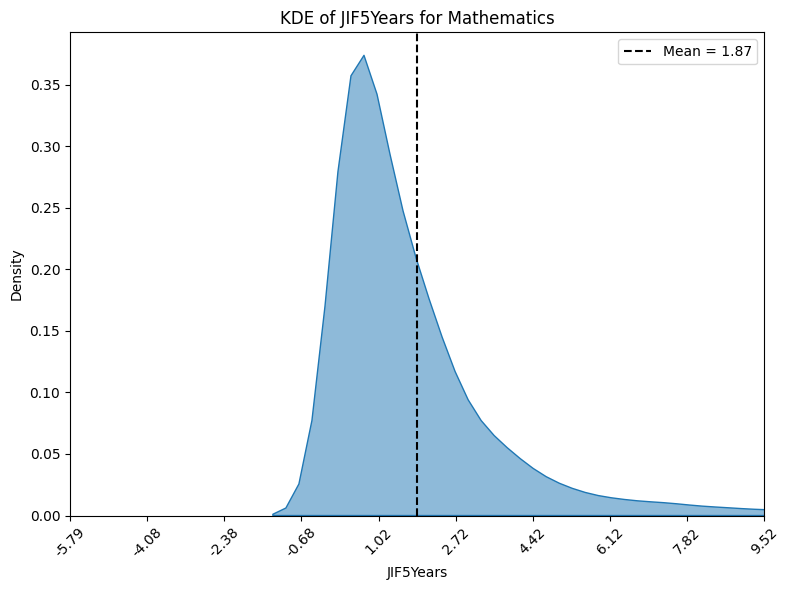

Plotting for Field: Geology


C:\Users\tasni\AppData\Local\Temp\ipykernel_36368\4209112351.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



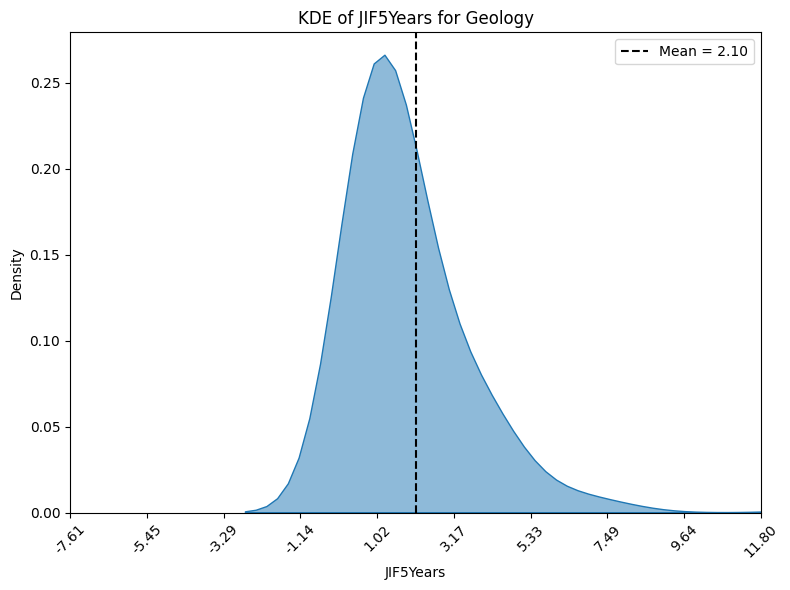

Plotting for Field: Physics


C:\Users\tasni\AppData\Local\Temp\ipykernel_36368\4209112351.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



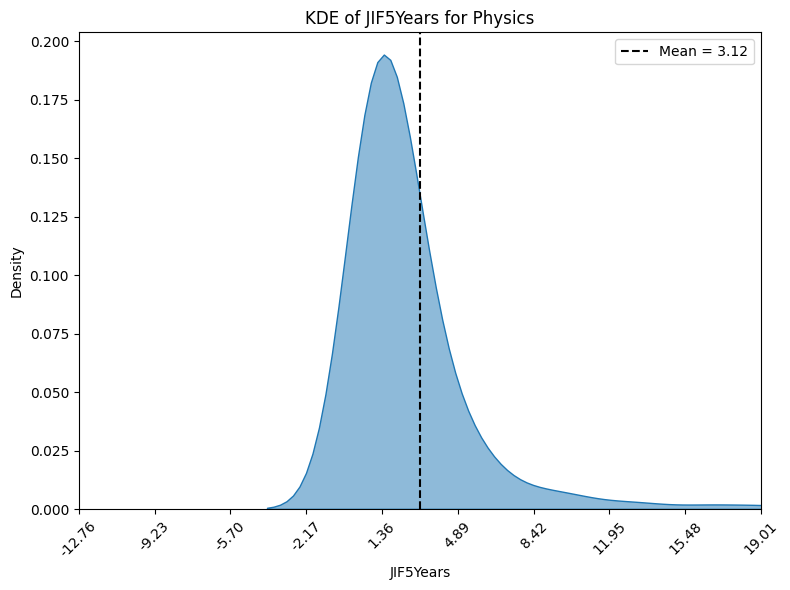

Plotting for Field: Engineering


C:\Users\tasni\AppData\Local\Temp\ipykernel_36368\4209112351.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



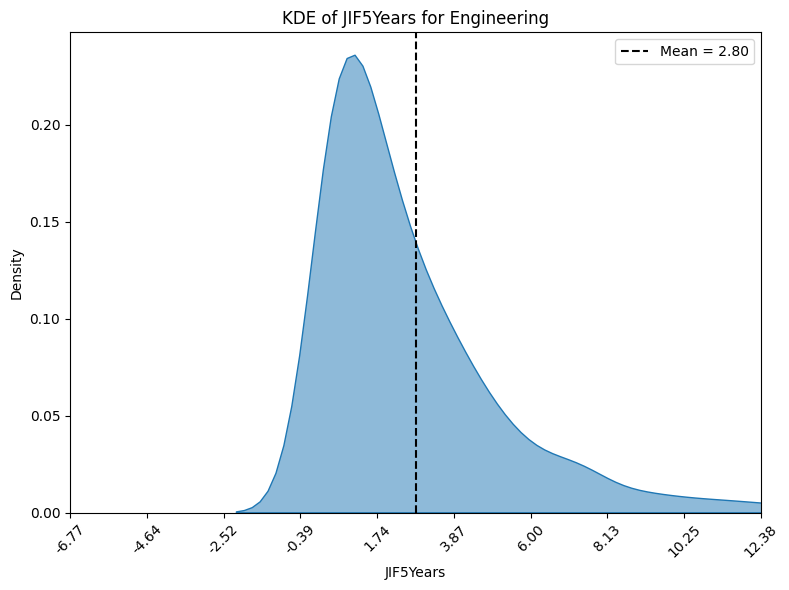

Plotting for Field: Environmental Science


C:\Users\tasni\AppData\Local\Temp\ipykernel_36368\4209112351.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



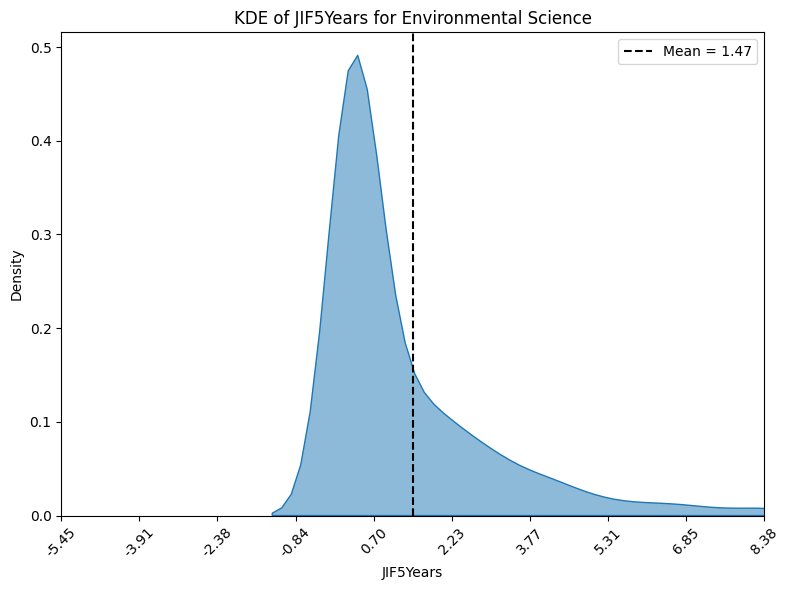

In [1660]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_gaussian_distribution(df, field_column, value_column, zoom_std=2,nticks=10):
    """
    Plots Gaussian (KDE) distributions for a specified field column and value column,
    zoomed to ±zoom_std standard deviations around the mean, with a vertical mean line.

    Args:
        df (pd.DataFrame): The input DataFrame.
        field_column (str): The column name representing the fields.
        value_column (str): The column name representing the values to plot.
        zoom_std (float): how many standard deviations around the mean to show.
    """
    # Ensure the value column is numeric
    df[value_column] = pd.to_numeric(df[value_column], errors='coerce').dropna()

    # Compute mean and stddev for zooming
    mean = df[value_column].mean()
    std = df[value_column].std()
    x_min, x_max = mean - zoom_std * std, mean + zoom_std * std

    plt.figure(figsize=(8, 6))
    sns.kdeplot(df[value_column], fill=True, alpha=0.5)

    # Draw vertical line at the mean
    plt.axvline(mean, color='k', linestyle='--', label=f'Mean = {mean:.2f}')

    # Zoom in
    plt.xlim(x_min, x_max)
    xmin, xmax = mean - zoom_std*std, mean + zoom_std*std
    ticks = np.linspace(xmin, xmax, nticks)
    plt.xticks(ticks, [f"{t:.2f}" for t in ticks], rotation=45)

    plt.title(f'KDE of {value_column} for {df[field_column].iat[0]}')
    plt.xlabel(value_column)
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()


# Usage: iterate over each field
for field in final_data['Field'].unique():
    subset = final_data[final_data['Field'] == field]
    print(f"Plotting for Field: {field}")
    plot_gaussian_distribution(subset, 'Field', 'JIF5Years', zoom_std=3)


In [1661]:
import pandas as pd

# (1) First—make sure your JIF5Years is numeric:
final_data['JIF5Years'] = pd.to_numeric(final_data['JIF5Years'], errors='coerce')

# (2) Define your thresholds
thresholds = {
    'Medicine': 1.0,
    'Biology': 1.0,
    'Materials Science': 1.5,
    'Computer Science': 0.8,
    'Chemistry': 1.5,
    'Mathematics': 0.7,
    'Geology': 0.8,
    'Physics': 1.0,
    'Engineering': 1.5,
    'Environmental Science': 0.5
}

# (3) Map thresholds onto a new column:
final_data['Threshold'] = final_data['Field'].map(thresholds)

# (4) Drop any fields that didn’t have a threshold defined (optional)
final_data = final_data.dropna(subset=['Threshold'])

# (5) Now filter safely:
filtered_df = final_data[final_data['JIF5Years'] >= final_data['Threshold']] \
                      .drop(columns='Threshold')


filtered_df.head(10)

C:\Users\tasni\AppData\Local\Temp\ipykernel_36368\67246383.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\tasni\AppData\Local\Temp\ipykernel_36368\67246383.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Name             Abbr Name       ISSN  \
0     CA-A CANCER JOURNAL FOR CLINICIANS      CA-CANCER J CLIN  0007-9235   
1          NATURE REVIEWS DRUG DISCOVERY   NAT REV DRUG DISCOV  1474-1776   
2                                 LANCET                LANCET  0140-6736   
3        NEW ENGLAND JOURNAL OF MEDICINE        NEW ENGL J MED  0028-4793   
4            BMJ-British Medical Journal        BMJ-BRIT MED J  0959-535X   
5  NATURE REVIEWS MOLECULAR CELL BIOLOGY  NAT REV MOL CELL BIO  1471-0072   
6       Nature Reviews Clinical Oncology    NAT REV CLIN ONCOL  1759-4774   
7               Nature Reviews Materials         NAT REV MATER  2058-8437   
8         Nature Reviews Disease Primers   NAT REV DIS PRIMERS  2056-676X   
9                  NATURE REVIEWS CANCER        NAT REV CANCER  1474-175X   

                    subcategory              Field  JIF5Years  
0                      ONCOLOGY           Medicine      297.0  
1       PHARMACOLOGY & PHARMACY           Medicine      114.9  
2  MEDICINE, GENERAL & INTERNAL           Medicine      106.9  
3  MEDICINE, GENERAL & INTERNAL           Medicine       94.3  
4  MEDICINE, GENERAL & INTERNAL           Medicine       69.9  
5                  CELL BIOLOGY            Biology      115.5  
6                      ONCOLOGY           Medicine       81.5  
7  NANOSCIENCE & NANOTECHNOLOGY  Materials Science       85.7  
8  MEDICINE, GENERAL & INTERNAL           Medicine       92.6  
9                      ONCOLOGY           Medicine       77.2

In [1662]:
len(final_data)

21800

In [1663]:
len(filtered_df)

14616

In [1664]:
if_data= filtered_df

In [1665]:
if_data.columns

Index(['Name', 'Abbr Name', 'ISSN', 'subcategory', 'Field', 'JIF5Years'], dtype='object')

In [1666]:
#final_data.to_csv('journals_field_IF.csv', index=False)

In [1667]:
# This finds rows where Field is None/NaN or exactly 'Unknown' or 'unknown'
mask = (
    if_data['Field'].isna() |
    (if_data['Field'].str.lower() == 'unknown')
)

# Count them
count = mask.sum()

print(f"Number of rows with missing or unknown Field: {count}")


Number of rows with missing or unknown Field: 0


In [1668]:
final_data.columns


Index(['Name', 'Abbr Name', 'ISSN', 'subcategory', 'Field', 'JIF5Years',
       'Threshold'],
      dtype='object')

In [1669]:
import pandas as pd

# 1) Make lowercase, strip whitespace, replace & with “and” on both DataFrames
def normalize_name(col):
    return col.str.lower().str.strip().str.replace(r'\s*&\s*', ' and ', regex=True)

# normalize PublicationVenueName in sem_df
sem_df = sem_df.copy()
sem_df['Venue_norm'] = normalize_name(sem_df['PublicationVenueName'])

# normalize Name and Abbr Name in final_data
final_data = final_data.copy()
final_data['Name_norm']      = normalize_name(final_data['Name'])
final_data['Abbr_norm']      = normalize_name(final_data['Abbr Name'])

# 2) Merge on the normalized columns
merged_df = (
    sem_df
    # first try matching on full Name
    .merge(
        final_data[['Name_norm','subcategory','Field','JIF5Years']],
        how='left',
        left_on='Venue_norm',
        right_on='Name_norm'
    )
    # then try Abbr Name
    .merge(
        final_data[['Abbr_norm','subcategory','Field','JIF5Years']],
        how='left',
        left_on='Venue_norm',
        right_on='Abbr_norm',
        suffixes=('','_abbr')
    )
)

# 3) Coalesce the two matches
for col in ('subcategory', 'Field', 'JIF5Years'):
    if f"{col}_abbr" in merged_df.columns:
        merged_df[col] = merged_df[col].combine_first(merged_df[f"{col}_abbr"])

# 4) Drop helper columns
merged_df = merged_df.drop(columns=[
    'Name_norm', 'Abbr_norm', 'Venue_norm',
    'subcategory_abbr', 'Field_abbr', 'JIF5Years_abbr'
], errors='ignore')

# Your merged_df now handles “&” vs “and”
merged_df.head()


Title Abstract  \
0  Classical and quantum cosmology of t...     None   
1  Reduced dimensionality quantum dynam...     None   
2  Imaging moiré excited states with ph...     None   
3  A fresh look at the calculation of t...     None   
4  High S/N crystallinity measurement a...     None   

                      PublicationVenueName PublicationVenueType    Year  \
0  Physical Review D, Particles and fields                 None  1985.0   
1          Journal of Physical Chemistry A              journal  2009.0   
2                         Nature Materials              journal  2024.0   
3  Journal of Cosmology and Astropartic...              journal  2018.0   
4  2010 35th IEEE Photovoltaic Speciali...                 None  2010.0   

  ReferenceCount  CitationCount  InfluentialCitationCount  \
0           None            317                        12   
1           None             25                         1   
2           None             14                         1   
3           None             45                         1   
4           None              0                         0   

           FieldsOfStudy          PublicationTypes PublicationDate  \
0    [Physics, Medicine]  [JournalArticle, Review]      1985-11-15   
1  [Chemistry, Medicine]          [JournalArticle]      2009-04-23   
2             [Medicine]          [JournalArticle]      2024-01-03   
3              [Physics]                      None      2018-11-22   
4    [Materials Science]              [Conference]      2010-06-20   

                                   Authors                          DOI  \
0                              A. Vilenkin    10.1103/PHYSREVD.32.2511,   
1        S. Remmert, S. T. Banks, D. Clary           10.1021/jp810803k,   
2  Hongyuan Li, Ziyu Xiang, Mit H. Naik...  10.1038/s41563-023-01753-4,   
3               J. Espinosa, T. Konstandin                         None   
4  Keiji Watanabe, T. Mine, R. Tsuchiya...   10.1109/PVSC.2010.5616196,   

        ISSN  year                            subcategory    Field  JIF5Years  
0  0556-2821  1985                                    NaN      NaN        NaN  
1  1089-5639  2009  PHYSICS, ATOMIC, MOLECULAR & CHEMICAL  Physics        2.5  
2  1476-1122  2024              PHYSICS, CONDENSED MATTER  Physics       44.0  
3  1475-7516  2018            PHYSICS, PARTICLES & FIELDS  Physics        5.5  
4       None  2010                                    NaN      NaN        NaN

In [1670]:
import pandas as pd

def normalize_name(col):
    return (col.str.lower()
               .str.strip()
               .str.replace(r'\s*&\s*', ' and ', regex=True))

# 1) Normalize
sem_df = sem_df.copy()
final_data = final_data.copy()
sem_df['Venue_norm']      = normalize_name(sem_df['PublicationVenueName'])
final_data['Name_norm']   = normalize_name(final_data['Name'])
final_data['Abbr_norm']   = normalize_name(final_data['Abbr Name'])

# 2) Two‐stage exact merge
merged_df = (
    sem_df
    .merge(
        final_data[['Name_norm','subcategory','Field','JIF5Years']],
        how='left',
        left_on='Venue_norm',
        right_on='Name_norm'
    )
    .merge(
        final_data[['Abbr_norm','subcategory','Field','JIF5Years']],
        how='left',
        left_on='Venue_norm',
        right_on='Abbr_norm',
        suffixes=('','_abbr')
    )
)

# Coalesce exact matches
for col in ('subcategory', 'Field', 'JIF5Years'):
    abbr_col = f"{col}_abbr"
    if abbr_col in merged_df.columns:
        merged_df[col] = merged_df[col].combine_first(merged_df[abbr_col])

# 3) Catch‐anywhere substring pass
# Build a tiny helper for faster lookups
lookup = final_data.set_index(['Name_norm','Abbr_norm'])[['subcategory','Field','JIF5Years']]

# Find rows still unmatched
mask = merged_df['subcategory'].isna()
for idx in merged_df.index[mask]:
    venue = merged_df.at[idx, 'Venue_norm']
    match = None

    # 3a) look for any normalized name or abbr inside venue
    for (nm, ab), row in lookup.iterrows():
        if nm in venue or ab in venue:
            match = row
            break

    if match is not None:
        # ← here’s the fix: use .loc instead of .at
        merged_df.loc[idx, ['subcategory','Field','JIF5Years']] = match.values


# 4) Clean up helper columns
merged_df = merged_df.drop(columns=[
    'Name_norm', 'Abbr_norm', 'Venue_norm',
    'subcategory_abbr', 'Field_abbr', 'JIF5Years_abbr'
], errors='ignore')

# merged_df now has both exact and substring based matches
merged_df.head()

Title Abstract  \
0  Classical and quantum cosmology of t...     None   
1  Reduced dimensionality quantum dynam...     None   
2  Imaging moiré excited states with ph...     None   
3  A fresh look at the calculation of t...     None   
4  High S/N crystallinity measurement a...     None   

                      PublicationVenueName PublicationVenueType    Year  \
0  Physical Review D, Particles and fields                 None  1985.0   
1          Journal of Physical Chemistry A              journal  2009.0   
2                         Nature Materials              journal  2024.0   
3  Journal of Cosmology and Astropartic...              journal  2018.0   
4  2010 35th IEEE Photovoltaic Speciali...                 None  2010.0   

  ReferenceCount  CitationCount  InfluentialCitationCount  \
0           None            317                        12   
1           None             25                         1   
2           None             14                         1   
3           None             45                         1   
4           None              0                         0   

           FieldsOfStudy          PublicationTypes PublicationDate  \
0    [Physics, Medicine]  [JournalArticle, Review]      1985-11-15   
1  [Chemistry, Medicine]          [JournalArticle]      2009-04-23   
2             [Medicine]          [JournalArticle]      2024-01-03   
3              [Physics]                      None      2018-11-22   
4    [Materials Science]              [Conference]      2010-06-20   

                                   Authors                          DOI  \
0                              A. Vilenkin    10.1103/PHYSREVD.32.2511,   
1        S. Remmert, S. T. Banks, D. Clary           10.1021/jp810803k,   
2  Hongyuan Li, Ziyu Xiang, Mit H. Naik...  10.1038/s41563-023-01753-4,   
3               J. Espinosa, T. Konstandin                         None   
4  Keiji Watanabe, T. Mine, R. Tsuchiya...   10.1109/PVSC.2010.5616196,   

        ISSN  year                              subcategory             Field  \
0  0556-2821  1985              PHYSICS, PARTICLES & FIELDS           Physics   
1  1089-5639  2009    PHYSICS, ATOMIC, MOLECULAR & CHEMICAL           Physics   
2  1476-1122  2024                PHYSICS, CONDENSED MATTER           Physics   
3  1475-7516  2018              PHYSICS, PARTICLES & FIELDS           Physics   
4       None  2010  COMPUTER SCIENCE, INTERDISCIPLINARY ...  Computer Science   

   JIF5Years  
0        4.3  
1        2.5  
2       44.0  
3        5.5  
4        3.3

In [1671]:
keep_types = {'JournalArticle', 'Review'}

def is_core_type(types):
    # if it's not a list (e.g. None/NaN), treat as empty → no match
    if not isinstance(types, list):
        return False
    # check intersection
    return bool(set(types) & keep_types)

mask = merged_df['PublicationTypes'].apply(is_core_type)
clean_df = merged_df[mask].reset_index(drop=True)


In [1672]:
# If PublicationTypes is literally a list object:
mask_conf_only = merged_df['PublicationTypes'].apply(lambda x: x == ['conference'])
clean_df = merged_df.loc[~mask_conf_only].reset_index(drop=True)

# If PublicationTypes is stored as a string like "['conference']" or "conference":
# mask_conf_only = merged_df['PublicationTypes'].str.contains(r'\bconference\b', na=False)
# clean_df = merged_df[~mask_conf_only].reset_index(drop=True)


In [1673]:
merged_df.columns


Index(['Title', 'Abstract', 'PublicationVenueName', 'PublicationVenueType',
       'Year', 'ReferenceCount', 'CitationCount', 'InfluentialCitationCount',
       'FieldsOfStudy', 'PublicationTypes', 'PublicationDate', 'Authors',
       'DOI', 'ISSN', 'year', 'subcategory', 'Field', 'JIF5Years'],
      dtype='object')

In [1674]:
sem_df = clean_df

In [1675]:
len(sem_df)

365

In [1676]:
# count papers per Field and take the top 5
top5_fields = sem_df['Field'].value_counts().head(5)

print("Top 5 paper fields:")
print(top5_fields)


Top 5 paper fields:
Field
Physics              187
Mathematics           62
Materials Science     39
Chemistry             34
Engineering           12
Name: count, dtype: int64


In [1677]:
sem_df.head()

Title Abstract  \
0  Classical and quantum cosmology of t...     None   
1  Reduced dimensionality quantum dynam...     None   
2  Imaging moiré excited states with ph...     None   
3  A fresh look at the calculation of t...     None   
4  High S/N crystallinity measurement a...     None   

                      PublicationVenueName PublicationVenueType    Year  \
0  Physical Review D, Particles and fields                 None  1985.0   
1          Journal of Physical Chemistry A              journal  2009.0   
2                         Nature Materials              journal  2024.0   
3  Journal of Cosmology and Astropartic...              journal  2018.0   
4  2010 35th IEEE Photovoltaic Speciali...                 None  2010.0   

  ReferenceCount  CitationCount  InfluentialCitationCount  \
0           None            317                        12   
1           None             25                         1   
2           None             14                         1   
3           None             45                         1   
4           None              0                         0   

           FieldsOfStudy          PublicationTypes PublicationDate  \
0    [Physics, Medicine]  [JournalArticle, Review]      1985-11-15   
1  [Chemistry, Medicine]          [JournalArticle]      2009-04-23   
2             [Medicine]          [JournalArticle]      2024-01-03   
3              [Physics]                      None      2018-11-22   
4    [Materials Science]              [Conference]      2010-06-20   

                                   Authors                          DOI  \
0                              A. Vilenkin    10.1103/PHYSREVD.32.2511,   
1        S. Remmert, S. T. Banks, D. Clary           10.1021/jp810803k,   
2  Hongyuan Li, Ziyu Xiang, Mit H. Naik...  10.1038/s41563-023-01753-4,   
3               J. Espinosa, T. Konstandin                         None   
4  Keiji Watanabe, T. Mine, R. Tsuchiya...   10.1109/PVSC.2010.5616196,   

        ISSN  year                              subcategory             Field  \
0  0556-2821  1985              PHYSICS, PARTICLES & FIELDS           Physics   
1  1089-5639  2009    PHYSICS, ATOMIC, MOLECULAR & CHEMICAL           Physics   
2  1476-1122  2024                PHYSICS, CONDENSED MATTER           Physics   
3  1475-7516  2018              PHYSICS, PARTICLES & FIELDS           Physics   
4       None  2010  COMPUTER SCIENCE, INTERDISCIPLINARY ...  Computer Science   

   JIF5Years  
0        4.3  
1        2.5  
2       44.0  
3        5.5  
4        3.3

In [1678]:
import plotly.graph_objects as go

# 1. Group by year and Field, then count papers
counts = sem_df.groupby(['year', 'Field']).size().reset_index(name='count')

# 2. Pivot so each Field becomes its own column
pivot = counts.pivot(index='year', columns='Field', values='count').fillna(0)

# 3. Create a Plotly figure
fig = go.Figure()

# Add a line for each Field
for field in pivot.columns:
  fig.add_trace(go.Scatter(
    x=pivot.index,
    y=pivot[field],
    mode='lines+markers',
    name=field,
    hovertemplate='Year: %{x}<br>Count: %{y}<extra></extra>'
  ))

# Update layout
fig.update_layout(
  title='Number of Papers Filed by Year by Field',
  xaxis_title='Year',
  yaxis_title='Number of Papers',
  legend_title='Field',
  template='plotly_white',
  hovermode='x unified'
)

# Show the plot
fig.show()


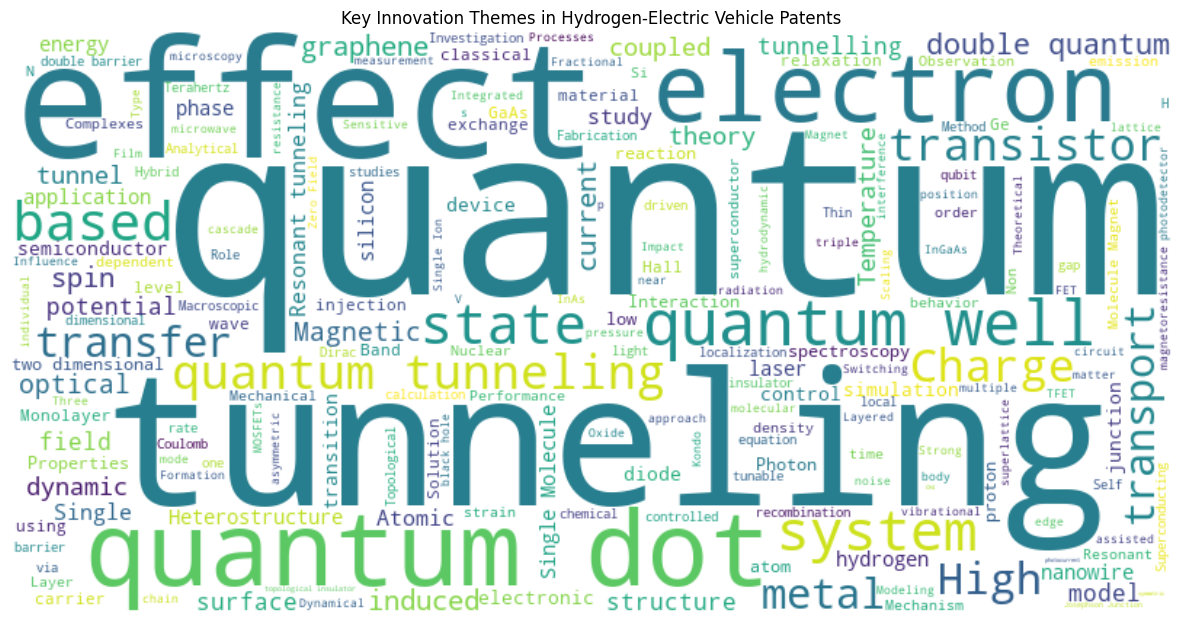

In [1679]:
# Combine all titles
text = ' '.join(sem_df['Title'].dropna().astype(str))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Key Innovation Themes in Hydrogen-Electric Vehicle Patents')
plt.show()

**openALex api**

In [1]:
import requests

def fetch_openalex_works(max_docs=300, per_page=200):
    # Validate per_page (OpenAlex allows 1-200 per request)
    per_page = min(max(per_page, 1), 200)
    
    filters = {
        "title_and_abstract.search": "quantum",
        "fulltext.search": "tunneling"  # Fixed: separate filter for fulltext
    }

    url = "https://api.openalex.org/works"
    params = {
        "filter": ",".join([f"{k}:{v}" for k, v in filters.items()]),
        "per_page": per_page,
        "cursor": "*"  # Initialize cursor for pagination
    }

    all_works = []
    total_docs_retrieved = 0
    
    while total_docs_retrieved < max_docs:
        response = requests.get(url, params=params)
        results = response.json()
        
        # Add the current page results
        current_works = results.get("results", [])
        all_works.extend(current_works)
        
        # Update counters
        total_docs_retrieved += len(current_works)
        
        # Check if we've reached our limit or end of results
        if not current_works or total_docs_retrieved >= max_docs:
            break
            
        # Get next cursor for pagination
        params["cursor"] = results.get("meta", {}).get("next_cursor")

    return all_works[:max_docs]  # Return exactly max_docs


FWCI compares the number of citations a work receives to the average citations received by similar works (same field, publication year, and document type).
FWCI= Work’s citations / Expected citations for similar works


Field-Weighted Citation Impact,

In [2]:
documents = fetch_openalex_works(max_docs=470, per_page=200)
print(f"Fetched {len(documents)} documents")

Fetched 470 documents


In [12]:
documents[1]['authorships']  # Display the first document

[{'author_position': 'first',
  'author': {'id': 'https://openalex.org/A5109936519',
   'display_name': 'Michael J. S. Dewar',
   'orcid': None},
  'institutions': [],
  'countries': [],
  'is_corresponding': False,
  'raw_author_name': 'Michael J. S. Dewar',
  'raw_affiliation_strings': [],
  'affiliations': []},
 {'author_position': 'middle',
  'author': {'id': 'https://openalex.org/A5062770502',
   'display_name': 'Eve G. Zoebisch',
   'orcid': None},
  'institutions': [],
  'countries': [],
  'is_corresponding': False,
  'raw_author_name': 'Eve G. Zoebisch',
  'raw_affiliation_strings': [],
  'affiliations': []},
 {'author_position': 'middle',
  'author': {'id': 'https://openalex.org/A5054216191',
   'display_name': 'Eamonn F. Healy',
   'orcid': 'https://orcid.org/0000-0001-8479-7712'},
  'institutions': [],
  'countries': [],
  'is_corresponding': False,
  'raw_author_name': 'Eamonn F. Healy',
  'raw_affiliation_strings': [],
  'affiliations': []},
 {'author_position': 'last',
  

In [10]:
import pandas as pd

def process_documents(documents):
    rows = []
    
    for doc in documents:
        # Handle nested structures safely with fallback defaults
        primary_location = doc.get('primary_location') or {}
        source = primary_location.get('source') or {}
        primary_topic = doc.get('primary_topic') or {}
        field = primary_topic.get('field') or {}
        domain = primary_topic.get('domain') or {}
        
        # Process keywords
        keywords = doc.get('keywords', []) or []
        keyword_names = [k.get('display_name', '') for k in keywords]
        keyword_scores = [k.get('score', '') for k in keywords]
        
        # Process locations with None handling
        locations = doc.get('locations', []) or []
        location_sources = [
            (loc.get('source') or {}).get('display_name', '')  
            for loc in locations if loc
        ]
        
        # Extract DOI (preferred top-level, fallback to ids)
        raw_doi = doc.get('doi') or (doc.get('ids') or {}).get('doi') or ''
        doi = raw_doi.split('doi.org/')[-1].strip() if raw_doi else ''

        # Process authorships countries: each authorship dict has a 'countries' key
        authorships = doc.get('authorships', []) or []
        # collect all non-empty country values
        countries = [auth.get('countries') for auth in authorships if auth.get('countries')]
        # flatten if any entries are lists
        flat_countries = []
        for c in countries:
            if isinstance(c, list):
                flat_countries.extend(c)
            else:
                flat_countries.append(c)
        # dedupe preserving order
        unique_countries = list(dict.fromkeys(flat_countries))
        countries_str = ", ".join(unique_countries)
        
        row = {
            'doi': doi,
            'title': doc.get('title'),
            'display_name': doc.get('display_name'),
            'relevance_score': doc.get('relevance_score'),
            'publication_year': doc.get('publication_year'),
            'type_crossref': doc.get('type_crossref'),
            'fwci': doc.get('fwci'),
            
            # Primary location information
            'primary_location.source.display_name': source.get('display_name'),
            'primary_location.source.issn_l': source.get('issn_l'),
            'primary_location.source.host_organization_name': source.get('host_organization_name'),
            'primary_location.source.host_organization_lineage_names': " | ".join(
                source.get('host_organization_lineage_names', [])
            ),
            'primary_location.source.type': source.get('type'),
            
            # Primary topic information
            'primary_topic.display_name': primary_topic.get('display_name'),
            'primary_topic.field.display_name': field.get('display_name'),
            'primary_topic.domain.display_name': domain.get('display_name'),
            
            # Keywords information
            'keywords.display_name': ", ".join(filter(None, keyword_names)),
            'keywords.score': ", ".join(map(str, keyword_scores)),
            
            # Locations information
            'locations.source.display_name': ", ".join(filter(None, location_sources)),

            # Authorships countries extracted directly from each authorship dict
            'authorships.countries': countries_str
        }
        
        rows.append(row)
    
    return pd.DataFrame(rows)

# Create the DataFrame
AIex_df = process_documents(documents)


In [13]:
AIex_df.head()

doi  \
0  10.1088/0953-8984/21/39/395502   
1             10.1021/ja00299a024   
2         10.1103/physreva.57.120   
3    10.1126/science.264.5158.553   
4   10.1103/physrevlett.95.226801   

                                               title  \
0  QUANTUM ESPRESSO: a modular and open-source so...   
1  Development and use of quantum mechanical mole...   
2              Quantum computation with quantum dots   
3                              Quantum Cascade Laser   
4               Quantum Spin Hall Effect in Graphene   

                                        display_name  relevance_score  \
0  QUANTUM ESPRESSO: a modular and open-source so...        5134.4053   
1  Development and use of quantum mechanical mole...        4467.4470   
2              Quantum computation with quantum dots        4236.3720   
3                              Quantum Cascade Laser        3181.8477   
4               Quantum Spin Hall Effect in Graphene        3116.4740   

   publication_year    type_crossref     fwci  \
0              2009  journal-article  293.905   
1              1985  journal-article   81.069   
2              1998  journal-article   58.000   
3              1994  journal-article   54.388   
4              2005  journal-article   31.999   

       primary_location.source.display_name primary_location.source.issn_l  \
0       Journal of Physics Condensed Matter                      0953-8984   
1  Journal of the American Chemical Society                      0002-7863   
2                         Physical Review A                      1050-2947   
3                                   Science                      0036-8075   
4                   Physical Review Letters                      0031-9007   

      primary_location.source.host_organization_name  \
0                                     IOP Publishing   
1                          American Chemical Society   
2                          American Physical Society   
3  American Association for the Advancement of Sc...   
4                          American Physical Society   

  primary_location.source.host_organization_lineage_names  \
0              Institute of Physics | IOP Publishing        
1                          American Chemical Society        
2                          American Physical Society        
3  American Association for the Advancement of Sc...        
4                          American Physical Society        

  primary_location.source.type                primary_topic.display_name  \
0                      journal  Quantum and electron transport phenomena   
1                      journal         Various Chemistry Research Topics   
2                      journal  Quantum and electron transport phenomena   
3                      journal       Spectroscopy and Laser Applications   
4                      journal  Quantum and electron transport phenomena   

  primary_topic.field.display_name primary_topic.domain.display_name  \
0            Physics and Astronomy                 Physical Sciences   
1                        Chemistry                 Physical Sciences   
2            Physics and Astronomy                 Physical Sciences   
3                        Chemistry                 Physical Sciences   
4            Physics and Astronomy                 Physical Sciences   

                         keywords.display_name         keywords.score  \
0                                                                       
1                             Icon, Altmetrics  0.6934817, 0.64437044   
2                                Universal set             0.63148177   
3  Population inversion, Quantum cascade laser   0.6408163, 0.4992752   
4                                                                       

                       locations.source.display_name   authorships.countries  
0  Journal of Physics Condensed Matter, HAL (Le C...  IT, US, FR, DE, SI, CH  
1           Journal of the American Chemical Society                        

In [14]:
len(AIex_df)

470

In [16]:
column_rename_map = {
    'title': 'title',
    'display_name': 'official_title',
    'relevance_score': 'relevance',
    'publication_year': 'publication_year',
    'type_crossref': 'document_type',
    'fwci': 'field_weighted_citation_impact',
    'doi': 'DOI',
    
    # Primary location information
    'primary_location.source.display_name': 'journal_name',
    'primary_location.source.issn_l': 'journal_issn_l',
    'primary_location.source.host_organization_name': 'publisher',
    'primary_location.source.host_organization_lineage_names': 'publisher_hierarchy',
    'primary_location.source.type': 'source_type',
    
    # Primary topic information
    'primary_topic.display_name': 'main_topic',
    'primary_topic.field.display_name': 'research_field',
    'primary_topic.domain.display_name': 'academic_domain',
    
    # Keywords information
    'keywords.display_name': 'keywords',
    'keywords.score': 'keyword_relevance_score',
    
    # Locations information
    'locations.source.display_name': 'all_journal_sources',
    'authorships.countries': 'authorships_countries'

}

AIex_df = AIex_df.rename(columns=column_rename_map)

In [17]:

AIex_df.isna().sum()

DOI                               0
title                             0
official_title                    0
relevance                         0
publication_year                  0
document_type                     0
field_weighted_citation_impact    1
journal_name                      0
journal_issn_l                    2
publisher                         3
publisher_hierarchy               0
source_type                       0
main_topic                        0
research_field                    0
academic_domain                   0
keywords                          0
keyword_relevance_score           0
all_journal_sources               0
authorships_countries             0
dtype: int64

In [18]:
# 1) Force everything to string, strip, then measure length
lengths = AIex_df['official_title'] \
    .astype(str) \
    .str.strip() \
    .str.len()

# 2) How many have length == 0?
n_blank = (lengths == 0).sum()
print(f"Number of truly blank venue names: {n_blank}")

# 3) (Optional) inspect a few reprs to understand what's in there
print(AIex_df['official_title']
      .head(10)
      .apply(lambda x: repr(x)))


Number of truly blank venue names: 0
0    'QUANTUM ESPRESSO: a modular and open-source s...
1    'Development and use of quantum mechanical mol...
2              'Quantum computation with quantum dots'
3                              'Quantum Cascade Laser'
4               'Quantum Spin Hall Effect in Graphene'
5    'Quantum phase transition from a superfluid to...
6                               'Quantum cryptography'
7       'Fault-tolerant quantum computation by anyons'
8                                  'Quantum computers'
9    'Coherent Manipulation of Coupled Electron Spi...
Name: official_title, dtype: object


In [1690]:
def is_empty(value):
    if pd.isna(value):
        return True
    if isinstance(value, (list, dict)) and len(value) == 0:
        return True
    if isinstance(value, str) and value.strip() == '':
        return True
    if isinstance(value, str) and value.strip() == "{}":
        return True
    return False

empty_cells = AIex_df.applymap(is_empty)
rows_with_empty_values = empty_cells.any(axis=1).sum()
print(f"\nRows with any empty values: {rows_with_empty_values}")


Rows with any empty values: 89


C:\Users\tasni\AppData\Local\Temp\ipykernel_36368\3095226023.py:12: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



In [19]:
import pandas as pd

def is_empty(value):
    # 1) True for pandas NA/NaN
    if pd.isna(value):
        return True
    # 2) True for empty list or dict
    if isinstance(value, (list, dict)) and len(value) == 0:
        return True
    # 3) Convert everything else to string, strip whitespace
    s = str(value).strip()
    # 4) True if that stripped string is empty or literally "{}" or "None"
    if s == '' or s == '{}' or s.lower() == 'none' or s.lower() == 'nan':
        return True
    return False

# Now apply it to the whole DataFrame:
empty_cells = AIex_df.applymap(is_empty)

# Count empties per column:
empty_per_column = empty_cells.sum()

# Keep only columns with at least one empty:
empty_per_column = empty_per_column[empty_per_column > 0]

print("Empty‐value counts by column:")
print(empty_per_column)

# If you also want to know which rows (indices) have ANY empty in them:
rows_with_any_empty = empty_cells.any(axis=1)
print(f"\nNumber of rows containing at least one empty cell: {rows_with_any_empty.sum()}")
print("Indices of those rows:", AIex_df.index[rows_with_any_empty].tolist())


Empty‐value counts by column:
field_weighted_citation_impact     1
journal_issn_l                     2
publisher                          3
publisher_hierarchy                3
keywords                          87
keyword_relevance_score           87
authorships_countries             11
dtype: int64

Number of rows containing at least one empty cell: 98
Indices of those rows: [0, 1, 4, 6, 8, 10, 17, 28, 34, 39, 40, 41, 49, 56, 65, 67, 69, 73, 77, 79, 87, 93, 102, 105, 107, 113, 115, 119, 126, 128, 132, 148, 152, 156, 157, 158, 160, 162, 171, 176, 182, 191, 194, 198, 200, 201, 202, 204, 205, 208, 217, 219, 233, 243, 245, 248, 253, 259, 267, 274, 275, 278, 279, 305, 309, 315, 316, 323, 328, 334, 339, 341, 342, 343, 346, 348, 352, 360, 366, 368, 373, 377, 381, 386, 394, 399, 400, 402, 407, 418, 434, 436, 441, 450, 453, 462, 465, 467]


C:\Users\tasni\AppData\Local\Temp\ipykernel_18828\72217640.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  empty_cells = AIex_df.applymap(is_empty)


In [20]:
# 1) Build the boolean mask of emptiness
empty_cells = AIex_df.applymap(is_empty)

# 2) Sum down each column to count empties
empty_per_column = empty_cells.sum()

# 3) (Optional) Filter to only columns with at least one empty
empty_per_column = empty_per_column[empty_per_column > 0]

print("Empty‐value counts by column:")
print(empty_per_column)


Empty‐value counts by column:
field_weighted_citation_impact     1
journal_issn_l                     2
publisher                          3
publisher_hierarchy                3
keywords                          87
keyword_relevance_score           87
authorships_countries             11
dtype: int64


C:\Users\tasni\AppData\Local\Temp\ipykernel_18828\4252667496.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  empty_cells = AIex_df.applymap(is_empty)


In [21]:
AIex_df.head()

DOI  \
0  10.1088/0953-8984/21/39/395502   
1             10.1021/ja00299a024   
2         10.1103/physreva.57.120   
3    10.1126/science.264.5158.553   
4   10.1103/physrevlett.95.226801   

                                               title  \
0  QUANTUM ESPRESSO: a modular and open-source so...   
1  Development and use of quantum mechanical mole...   
2              Quantum computation with quantum dots   
3                              Quantum Cascade Laser   
4               Quantum Spin Hall Effect in Graphene   

                                      official_title  relevance  \
0  QUANTUM ESPRESSO: a modular and open-source so...  5134.4053   
1  Development and use of quantum mechanical mole...  4467.4470   
2              Quantum computation with quantum dots  4236.3720   
3                              Quantum Cascade Laser  3181.8477   
4               Quantum Spin Hall Effect in Graphene  3116.4740   

   publication_year    document_type  field_weighted_citation_impact  \
0              2009  journal-article                         293.905   
1              1985  journal-article                          81.069   
2              1998  journal-article                          58.000   
3              1994  journal-article                          54.388   
4              2005  journal-article                          31.999   

                               journal_name journal_issn_l  \
0       Journal of Physics Condensed Matter      0953-8984   
1  Journal of the American Chemical Society      0002-7863   
2                         Physical Review A      1050-2947   
3                                   Science      0036-8075   
4                   Physical Review Letters      0031-9007   

                                           publisher  \
0                                     IOP Publishing   
1                          American Chemical Society   
2                          American Physical Society   
3  American Association for the Advancement of Sc...   
4                          American Physical Society   

                                 publisher_hierarchy source_type  \
0              Institute of Physics | IOP Publishing     journal   
1                          American Chemical Society     journal   
2                          American Physical Society     journal   
3  American Association for the Advancement of Sc...     journal   
4                          American Physical Society     journal   

                                 main_topic         research_field  \
0  Quantum and electron transport phenomena  Physics and Astronomy   
1         Various Chemistry Research Topics              Chemistry   
2  Quantum and electron transport phenomena  Physics and Astronomy   
3       Spectroscopy and Laser Applications              Chemistry   
4  Quantum and electron transport phenomena  Physics and Astronomy   

     academic_domain                                     keywords  \
0  Physical Sciences                                                
1  Physical Sciences                             Icon, Altmetrics   
2  Physical Sciences                                Universal set   
3  Physical Sciences  Population inversion, Quantum cascade laser   
4  Physical Sciences                                                

  keyword_relevance_score                                all_journal_sources  \
0                          Journal of Physics Condensed Matter, HAL (Le C...   
1   0.6934817, 0.64437044           Journal of the American Chemical Society   
2              0.63148177  Physical Review A, arXiv (Cornell University),...   
3    0.6408163, 0.4992752                                    Science, PubMed   
4                          Physical Review Letters, arXiv (Cornell Univer...   

    authorships_countries  
0  IT, US, FR, DE, SI, CH  
1                          
2                  CH, US  
3                      US  
4                      US

In [22]:
# Clean ISSNs by removing hyphens and whitespace, convert to uppercase
def clean_issn(issn):
    if pd.isna(issn):
        return None
    return str(issn).replace("-", "").strip().upper()

# Prepare journal data
journal_df = if_data.copy()
journal_df['ISSN_clean'] = journal_df['ISSN'].apply(clean_issn)

# Prepare paper data
paper_df = AIex_df.copy()
paper_df['journal_issn_l_clean'] = paper_df['journal_issn_l'].apply(clean_issn)

# Create ISSN to Field mapping (handling multiple ISSNs per journal)
issn_to_field = {}
for _, row in journal_df.iterrows():
    if row['ISSN_clean']:
        issn_list = [row['ISSN_clean']]  # Add logic here if ISSN column contains multiple values separated by commas
        for issn in issn_list:
            issn_to_field[issn] = row['Field']

# Map fields to papers and identify matches
paper_df['Field'] = paper_df['journal_issn_l_clean'].map(issn_to_field)
matched_mask = paper_df['Field'].notna()

print(f"Total papers: {len(paper_df)}")
print(f"Matched papers: {matched_mask.sum()}")
print(f"Unmatched papers: {len(paper_df) - matched_mask.sum()}")

# Create final dataframe with matched papers
final_df = paper_df[matched_mask].reset_index(drop=True)

# Optional: Analyze unmatched papers
unmatched_df = paper_df[~matched_mask]
print("\nSample unmatched papers:")
print(unmatched_df[['title', 'journal_issn_l']].head())

NameError: name 'if_data' is not defined

In [1695]:
final_df.head()

DOI                                    title  \
0  10.1088/0953-8984/21/39/395502  QUANTUM ESPRESSO: a modular and open...   
1             10.1021/ja00299a024  Development and use of quantum mecha...   
2    10.1126/science.264.5158.553                    Quantum Cascade Laser   
3   10.1103/physrevlett.95.226801     Quantum Spin Hall Effect in Graphene   
4                 10.1038/415039a  Quantum phase transition from a supe...   

                            official_title  relevance  publication_year  \
0  QUANTUM ESPRESSO: a modular and open...  5134.4053              2009   
1  Development and use of quantum mecha...  4467.4470              1985   
2                    Quantum Cascade Laser  3181.8477              1994   
3     Quantum Spin Hall Effect in Graphene  3116.4740              2005   
4  Quantum phase transition from a supe...  3059.9130              2002   

     document_type  field_weighted_citation_impact  \
0  journal-article                         293.905   
1  journal-article                          81.069   
2  journal-article                          54.388   
3  journal-article                          31.999   
4  journal-article                         165.780   

                              journal_name journal_issn_l  \
0      Journal of Physics Condensed Matter      0953-8984   
1  Journal of the American Chemical Soc...      0002-7863   
2                                  Science      0036-8075   
3                  Physical Review Letters      0031-9007   
4                                   Nature      0028-0836   

                                 publisher  \
0                           IOP Publishing   
1                American Chemical Society   
2  American Association for the Advance...   
3                American Physical Society   
4                         Nature Portfolio   

                       publisher_hierarchy source_type  \
0    Institute of Physics | IOP Publishing     journal   
1                American Chemical Society     journal   
2  American Association for the Advance...     journal   
3                American Physical Society     journal   
4       Nature Portfolio | Springer Nature     journal   

                                main_topic         research_field  \
0  Quantum and electron transport pheno...  Physics and Astronomy   
1        Various Chemistry Research Topics              Chemistry   
2      Spectroscopy and Laser Applications              Chemistry   
3  Quantum and electron transport pheno...  Physics and Astronomy   
4  Cold Atom Physics and Bose-Einstein ...  Physics and Astronomy   

     academic_domain                                 keywords  \
0  Physical Sciences                                            
1  Physical Sciences                         Icon, Altmetrics   
2  Physical Sciences  Population inversion, Quantum cascad...   
3  Physical Sciences                                            
4  Physical Sciences  Optical lattice, Mott insulator, Ult...   

                   keyword_relevance_score  \
0                                            
1                    0.6934817, 0.64437044   
2                     0.6408163, 0.4992752   
3                                            
4  0.84810317, 0.7205394, 0.67315894, 0...   

                       all_journal_sources journal_issn_l_clean        Field  
0  Journal of Physics Condensed Matter,...             09538984      Physics  
1  Journal of the American Chemical Soc...             00027863    Chemistry  
2                          Science, PubMed             00368075  Mathematics  
3  Physical Review Letters, arXiv (Corn...             00319007      Physics  
4                           Nature, PubMed             00280836  Mathematics

In [1696]:
AIex_df = final_df

In [1697]:
sem_df.columns

Index(['Title', 'Abstract', 'PublicationVenueName', 'PublicationVenueType',
       'Year', 'ReferenceCount', 'CitationCount', 'InfluentialCitationCount',
       'FieldsOfStudy', 'PublicationTypes', 'PublicationDate', 'Authors',
       'DOI', 'ISSN', 'year', 'subcategory', 'Field', 'JIF5Years'],
      dtype='object')

In [1698]:
sem_df.isnull().sum()

Title                         0
Abstract                    285
PublicationVenueName          0
PublicationVenueType        100
Year                          0
ReferenceCount              365
CitationCount                 0
InfluentialCitationCount      0
FieldsOfStudy                58
PublicationTypes            106
PublicationDate              17
Authors                       3
DOI                         122
ISSN                        103
year                         17
subcategory                  12
Field                        12
JIF5Years                    16
dtype: int64

In [1699]:
AIex_df.columns

Index(['DOI', 'title', 'official_title', 'relevance', 'publication_year',
       'document_type', 'field_weighted_citation_impact', 'journal_name',
       'journal_issn_l', 'publisher', 'publisher_hierarchy', 'source_type',
       'main_topic', 'research_field', 'academic_domain', 'keywords',
       'keyword_relevance_score', 'all_journal_sources',
       'journal_issn_l_clean', 'Field'],
      dtype='object')

In [1700]:
len(final_df)

392

In [1701]:
len(sem_df)

365

In [1702]:
len(AIex_df)

392

In [1703]:
AIex_df.columns

Index(['DOI', 'title', 'official_title', 'relevance', 'publication_year',
       'document_type', 'field_weighted_citation_impact', 'journal_name',
       'journal_issn_l', 'publisher', 'publisher_hierarchy', 'source_type',
       'main_topic', 'research_field', 'academic_domain', 'keywords',
       'keyword_relevance_score', 'all_journal_sources',
       'journal_issn_l_clean', 'Field'],
      dtype='object')

In [1704]:
sem_df.columns

Index(['Title', 'Abstract', 'PublicationVenueName', 'PublicationVenueType',
       'Year', 'ReferenceCount', 'CitationCount', 'InfluentialCitationCount',
       'FieldsOfStudy', 'PublicationTypes', 'PublicationDate', 'Authors',
       'DOI', 'ISSN', 'year', 'subcategory', 'Field', 'JIF5Years'],
      dtype='object')

In [1705]:
sem_df.rename(columns={'PublicationVenueName': 'journal_name','Title':'title'}, inplace=True)

In [1706]:
AIex_df.rename(columns={'document_type': 'PublicationTypes', 'Journal_issn_l': 'ISSN','research_field':'FieldsOfStudy','publication_year':'Year'}, inplace=True)

In [1707]:
import re, pandas as pd

def clean_doi(raw):
    if pd.isna(raw): return None
    s = str(raw).strip().lower()
    s = re.sub(r'^https?://(dx\.)?doi\.org/', '', s)
    s = re.sub(r'^doi:\s*', '', s)
    s = re.split(r'[\?#]', s)[0]
    return s.rstrip('/') or None

# restore doi_clean on both frames
sem_df['doi_clean']   = sem_df['DOI'].apply(clean_doi)
AIex_df['doi_clean']  = AIex_df['DOI'].apply(clean_doi)

# verify
print("sem_df columns:", sem_df.columns.tolist())
print("AIex_df columns:", AIex_df.columns.tolist())
print("Unique DOIs in sem_df:", sem_df['doi_clean'].nunique())


sem_df columns: ['title', 'Abstract', 'journal_name', 'PublicationVenueType', 'Year', 'ReferenceCount', 'CitationCount', 'InfluentialCitationCount', 'FieldsOfStudy', 'PublicationTypes', 'PublicationDate', 'Authors', 'DOI', 'ISSN', 'year', 'subcategory', 'Field', 'JIF5Years', 'doi_clean']
AIex_df columns: ['DOI', 'title', 'official_title', 'relevance', 'Year', 'PublicationTypes', 'field_weighted_citation_impact', 'journal_name', 'journal_issn_l', 'publisher', 'publisher_hierarchy', 'source_type', 'main_topic', 'FieldsOfStudy', 'academic_domain', 'keywords', 'keyword_relevance_score', 'all_journal_sources', 'journal_issn_l_clean', 'Field', 'doi_clean']
Unique DOIs in sem_df: 243


In [1708]:
import pandas as pd
from thefuzz import fuzz

# 0) assume sem_df, AIex_df already have doi_clean

# Count rows per DOI in sem_df
doi_counts = sem_df.groupby('doi_clean').size().to_frame('count').reset_index()

# 1) exact matches (only non‐null DOIs)
exact_matches = (
    pd.merge(
      sem_df[['doi_clean']].dropna().drop_duplicates(),
      AIex_df[['doi_clean']].dropna().drop_duplicates(),
      on='doi_clean',
      how='inner'
    )
)
print("Exact DOI matches:", len(exact_matches), 
      "unique DOIs:", exact_matches['doi_clean'].nunique())

# 2) build sem_non_matched after exact‐drop
sem_non = sem_df[~sem_df['doi_clean'].isin(exact_matches['doi_clean'])]
print("After exact-drop, sem_non rows:", len(sem_non),
      "unique DOIs:", sem_non['doi_clean'].nunique())

# 3) fuzzy match by title—but only for non-null DOIs
fuzzy = []
threshold = 85

# isolate AIex pool for speed
aiex_pool = AIex_df[~AIex_df['doi_clean'].isin(exact_matches['doi_clean'])]
aiex_pool = aiex_pool[aiex_pool['doi_clean'].notna()]

for s_idx, s_row in sem_non.iterrows():
    if pd.isna(s_row['doi_clean']): 
        continue
    best = {'score':0, 'aiex_doi':None}
    s_title = str(s_row['title']).lower().strip()
    for _, a_row in aiex_pool.iterrows():
        score = fuzz.token_set_ratio(s_title, str(a_row['title']).lower().strip())
        if score > best['score']:
            best = {'score':score, 'aiex_doi':a_row['doi_clean']}
    if best['score'] >= threshold:
        fuzzy.append({'sem_doi':s_row['doi_clean'], 'aiex_doi':best['aiex_doi'], 'score':best['score']})

fuzzy_sem_dois = {x['sem_doi'] for x in fuzzy}
print("Fuzzy matches (unique sem DOIs):", len(fuzzy_sem_dois))

# 4) union of exact+fuzzy DOIs to drop
to_drop = set(exact_matches['doi_clean']).union(fuzzy_sem_dois)
print("Total unique DOIs to drop:", len(to_drop))

# 5) final filter
sem_filtered = sem_df[~sem_df['doi_clean'].isin(to_drop)]
print("sem_df before:", len(sem_df), "after:", len(sem_filtered),
      "=> removed", len(sem_df)-len(sem_filtered), "rows")

# 6) combine
final = pd.concat([AIex_df, sem_filtered], ignore_index=True)
print("Final combined shape:", final.shape)


Exact DOI matches: 0 unique DOIs: 0


After exact-drop, sem_non rows: 365 unique DOIs: 243
Fuzzy matches (unique sem DOIs): 16
Total unique DOIs to drop: 16
sem_df before: 365 after: 349 => removed 16 rows
Final combined shape: (741, 32)


In [1709]:
# import pandas as pd

# df = final  # your combined dataframe

# # 1) Build groups of columns by their lowercase name
# from collections import defaultdict
# groups = defaultdict(list)
# for col in df.columns:
#     groups[col.lower()].append(col)

# # 2) For each group with >1 member, coalesce them
# for lower_name, cols in groups.items():
#     if len(cols) > 1:
#         # create a new Series by taking first non-null in each row
#         # across the columns in this group
#         df[lower_name] = df[cols].bfill(axis=1).iloc[:, 0]
#         # drop the old variants
#         df.drop(columns=cols, inplace=True)

# # 3) (Optional) if you’d rather keep a specific canonical name,
# #     you can now rename the lower_name back to e.g. Title or YEAR:
# # df.rename(columns={'title': 'Title', 'year': 'Year'}, inplace=True)


In [1710]:
final.isna().sum()

DOI                               122
title                               0
official_title                    349
relevance                         349
Year                                0
PublicationTypes                   99
field_weighted_citation_impact    349
journal_name                        0
journal_issn_l                    349
publisher                         350
publisher_hierarchy               349
source_type                       349
main_topic                        349
FieldsOfStudy                      55
academic_domain                   349
keywords                          349
keyword_relevance_score           349
all_journal_sources               349
journal_issn_l_clean              349
Field                               9
doi_clean                         122
Abstract                          662
PublicationVenueType              483
ReferenceCount                    741
CitationCount                     392
InfluentialCitationCount          392
PublicationD

In [1711]:
final.columns

Index(['DOI', 'title', 'official_title', 'relevance', 'Year',
       'PublicationTypes', 'field_weighted_citation_impact', 'journal_name',
       'journal_issn_l', 'publisher', 'publisher_hierarchy', 'source_type',
       'main_topic', 'FieldsOfStudy', 'academic_domain', 'keywords',
       'keyword_relevance_score', 'all_journal_sources',
       'journal_issn_l_clean', 'Field', 'doi_clean', 'Abstract',
       'PublicationVenueType', 'ReferenceCount', 'CitationCount',
       'InfluentialCitationCount', 'PublicationDate', 'Authors', 'ISSN',
       'year', 'subcategory', 'JIF5Years'],
      dtype='object')

In [1712]:
AIex_df.columns

Index(['DOI', 'title', 'official_title', 'relevance', 'Year',
       'PublicationTypes', 'field_weighted_citation_impact', 'journal_name',
       'journal_issn_l', 'publisher', 'publisher_hierarchy', 'source_type',
       'main_topic', 'FieldsOfStudy', 'academic_domain', 'keywords',
       'keyword_relevance_score', 'all_journal_sources',
       'journal_issn_l_clean', 'Field', 'doi_clean'],
      dtype='object')

In [1713]:
sem_df.columns

Index(['title', 'Abstract', 'journal_name', 'PublicationVenueType', 'Year',
       'ReferenceCount', 'CitationCount', 'InfluentialCitationCount',
       'FieldsOfStudy', 'PublicationTypes', 'PublicationDate', 'Authors',
       'DOI', 'ISSN', 'year', 'subcategory', 'Field', 'JIF5Years',
       'doi_clean'],
      dtype='object')

In [1714]:
sem_df.head(1)

title Abstract  \
0  Classical and quantum cosmology of t...     None   

                              journal_name PublicationVenueType    Year  \
0  Physical Review D, Particles and fields                 None  1985.0   

  ReferenceCount  CitationCount  InfluentialCitationCount  \
0           None            317                        12   

         FieldsOfStudy          PublicationTypes PublicationDate      Authors  \
0  [Physics, Medicine]  [JournalArticle, Review]      1985-11-15  A. Vilenkin   

                         DOI       ISSN  year                  subcategory  \
0  10.1103/PHYSREVD.32.2511,  0556-2821  1985  PHYSICS, PARTICLES & FIELDS   

     Field  JIF5Years                  doi_clean  
0  Physics        4.3  10.1103/physrevd.32.2511,

In [1715]:
AIex_df.head(1)

DOI                                    title  \
0  10.1088/0953-8984/21/39/395502  QUANTUM ESPRESSO: a modular and open...   

                            official_title  relevance  Year PublicationTypes  \
0  QUANTUM ESPRESSO: a modular and open...  5134.4053  2009  journal-article   

   field_weighted_citation_impact                         journal_name  \
0                         293.905  Journal of Physics Condensed Matter   

  journal_issn_l       publisher  ... source_type  \
0      0953-8984  IOP Publishing  ...     journal   

                                main_topic          FieldsOfStudy  \
0  Quantum and electron transport pheno...  Physics and Astronomy   

     academic_domain keywords keyword_relevance_score  \
0  Physical Sciences                                    

                       all_journal_sources journal_issn_l_clean    Field  \
0  Journal of Physics Condensed Matter,...             09538984  Physics   

                        doi_clean  
0  10.1088/0953-8984/21/39/395502  

[1 rows x 21 columns]

In [1716]:
final.isna().sum()

DOI                               122
title                               0
official_title                    349
relevance                         349
Year                                0
PublicationTypes                   99
field_weighted_citation_impact    349
journal_name                        0
journal_issn_l                    349
publisher                         350
publisher_hierarchy               349
source_type                       349
main_topic                        349
FieldsOfStudy                      55
academic_domain                   349
keywords                          349
keyword_relevance_score           349
all_journal_sources               349
journal_issn_l_clean              349
Field                               9
doi_clean                         122
Abstract                          662
PublicationVenueType              483
ReferenceCount                    741
CitationCount                     392
InfluentialCitationCount          392
PublicationD

In [1717]:
len(final)

741

In [1718]:
final.head()

DOI                                    title  \
0  10.1088/0953-8984/21/39/395502  QUANTUM ESPRESSO: a modular and open...   
1             10.1021/ja00299a024  Development and use of quantum mecha...   
2    10.1126/science.264.5158.553                    Quantum Cascade Laser   
3   10.1103/physrevlett.95.226801     Quantum Spin Hall Effect in Graphene   
4                 10.1038/415039a  Quantum phase transition from a supe...   

                            official_title  relevance    Year  \
0  QUANTUM ESPRESSO: a modular and open...  5134.4053  2009.0   
1  Development and use of quantum mecha...  4467.4470  1985.0   
2                    Quantum Cascade Laser  3181.8477  1994.0   
3     Quantum Spin Hall Effect in Graphene  3116.4740  2005.0   
4  Quantum phase transition from a supe...  3059.9130  2002.0   

  PublicationTypes  field_weighted_citation_impact  \
0  journal-article                         293.905   
1  journal-article                          81.069   
2  journal-article                          54.388   
3  journal-article                          31.999   
4  journal-article                         165.780   

                              journal_name journal_issn_l  \
0      Journal of Physics Condensed Matter      0953-8984   
1  Journal of the American Chemical Soc...      0002-7863   
2                                  Science      0036-8075   
3                  Physical Review Letters      0031-9007   
4                                   Nature      0028-0836   

                                 publisher  ... PublicationVenueType  \
0                           IOP Publishing  ...                  NaN   
1                American Chemical Society  ...                  NaN   
2  American Association for the Advance...  ...                  NaN   
3                American Physical Society  ...                  NaN   
4                         Nature Portfolio  ...                  NaN   

  ReferenceCount CitationCount InfluentialCitationCount PublicationDate  \
0            NaN           NaN                      NaN             NaN   
1            NaN           NaN                      NaN             NaN   
2            NaN           NaN                      NaN             NaN   
3            NaN           NaN                      NaN             NaN   
4            NaN           NaN                      NaN             NaN   

  Authors ISSN  year subcategory JIF5Years  
0     NaN  NaN  <NA>         NaN       NaN  
1     NaN  NaN  <NA>         NaN       NaN  
2     NaN  NaN  <NA>         NaN       NaN  
3     NaN  NaN  <NA>         NaN       NaN  
4     NaN  NaN  <NA>         NaN       NaN  

[5 rows x 32 columns]

In [1719]:
len(sem_df)

365

In [1720]:
len(AIex_df)

392

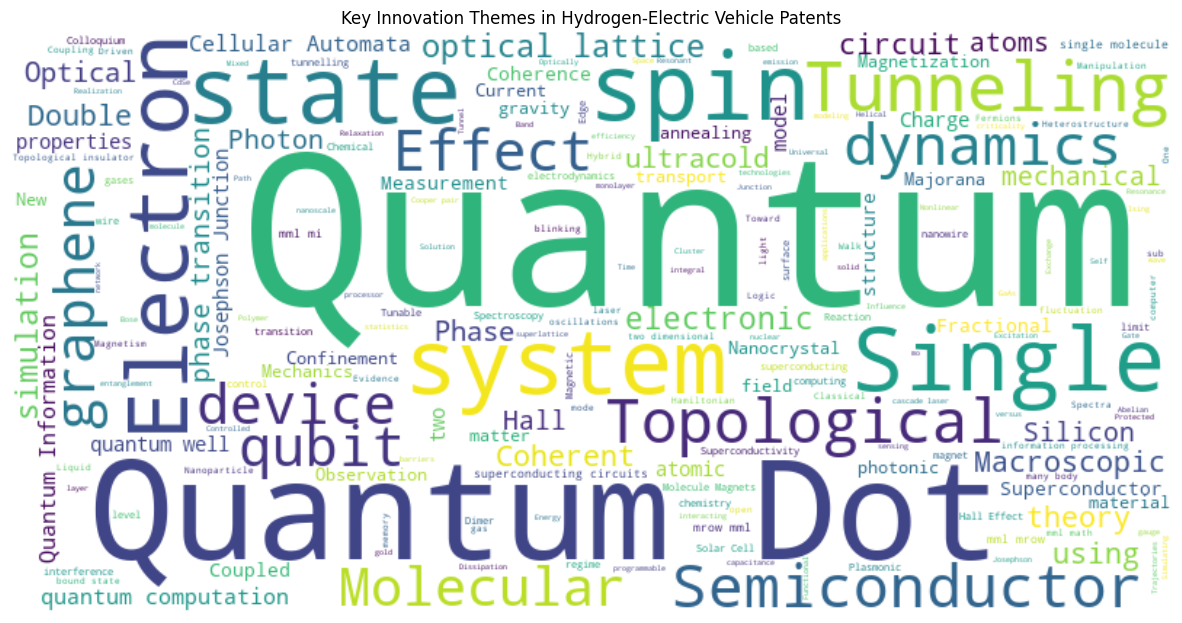

In [1721]:
# Combine all titles
text = ' '.join(AIex_df['title'].dropna().astype(str))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Key Innovation Themes in Hydrogen-Electric Vehicle Patents')
plt.show()

In [1722]:
AIex_df.columns

Index(['DOI', 'title', 'official_title', 'relevance', 'Year',
       'PublicationTypes', 'field_weighted_citation_impact', 'journal_name',
       'journal_issn_l', 'publisher', 'publisher_hierarchy', 'source_type',
       'main_topic', 'FieldsOfStudy', 'academic_domain', 'keywords',
       'keyword_relevance_score', 'all_journal_sources',
       'journal_issn_l_clean', 'Field', 'doi_clean'],
      dtype='object')

In [1725]:
import plotly.graph_objects as go

# 1. Group by year and Field, then count papers
counts = AIex_df.groupby(['Year', 'academic_domain']).size().reset_index(name='count')

# 2. Pivot so each Field becomes its own column
pivot = counts.pivot(index='Year', columns='academic_domain', values='count').fillna(0)

# 3. Create a Plotly figure
fig = go.Figure()

# Add a line for each Field
for field in pivot.columns:
  fig.add_trace(go.Scatter(
    x=pivot.index,
    y=pivot[field],
    mode='lines+markers',
    name=field,
    hovertemplate='Year: %{x}<br>Count: %{y}<extra></extra>'
  ))

# Update layout
fig.update_layout(
  title='Number of Papers Filed by Year by Field',
  xaxis_title='Year',
  yaxis_title='Number of Papers',
  legend_title='Field',
  template='plotly_white',
  hovermode='x unified'
)

# Show the plot
fig.show()


In [ ]:
final.columns

Index(['DOI', 'title', 'official_title', 'relevance', 'year',
       'PublicationTypes', 'field_weighted_citation_impact', 'journal_name',
       'journal_issn_l', 'publisher', 'publisher_hierarchy', 'source_type',
       'main_topic', 'FieldsOfStudy', 'academic_domain', 'keywords',
       'keyword_relevance_score', 'all_journal_sources',
       'journal_issn_l_clean', 'Field', 'doi_clean', 'Abstract',
       'PublicationVenueType', 'Year', 'ReferenceCount', 'CitationCount',
       'InfluentialCitationCount', 'PublicationDate', 'Authors', 'ISSN',
       'subcategory', 'JIF5Years'],
      dtype='object')

merged df filing distribution 

In [1726]:
import plotly.graph_objects as go

# 1. Group by year and Field, then count papers
counts = final.groupby(['Year', 'Field']).size().reset_index(name='count')

# 2. Pivot so each Field becomes its own column
pivot = counts.pivot(index='Year', columns='Field', values='count').fillna(0)

# 3. Create a Plotly figure
fig = go.Figure()

# Add a line for each Field
for field in pivot.columns:
  fig.add_trace(go.Scatter(
    x=pivot.index,
    y=pivot[field],
    mode='lines+markers',
    name=field,
    hovertemplate='Year: %{x}<br>Count: %{y}<extra></extra>'
  ))

# Update layout
fig.update_layout(
  title='Number of Papers Filed by Year by Field',
  xaxis_title='Year',
  yaxis_title='Number of Papers',
  legend_title='Field',
  template='plotly_white',
  hovermode='x unified'
)

# Show the plot
fig.show()


In [ ]:
final.columns

Index(['DOI', 'official_title', 'relevance', 'publication_year',
       'field_weighted_citation_impact', 'journal_issn_l', 'publisher',
       'publisher_hierarchy', 'source_type', 'main_topic', 'academic_domain',
       'keywords', 'keyword_relevance_score', 'all_journal_sources',
       'journal_issn_l_clean', 'Field', 'doi_clean', 'Abstract',
       'PublicationVenueType', 'Year', 'ReferenceCount', 'CitationCount',
       'InfluentialCitationCount', 'PublicationDate', 'Authors', 'ISSN',
       'subcategory', 'JIF5Years', 'publicationtypes', 'fieldsofstudy'],
      dtype='object')

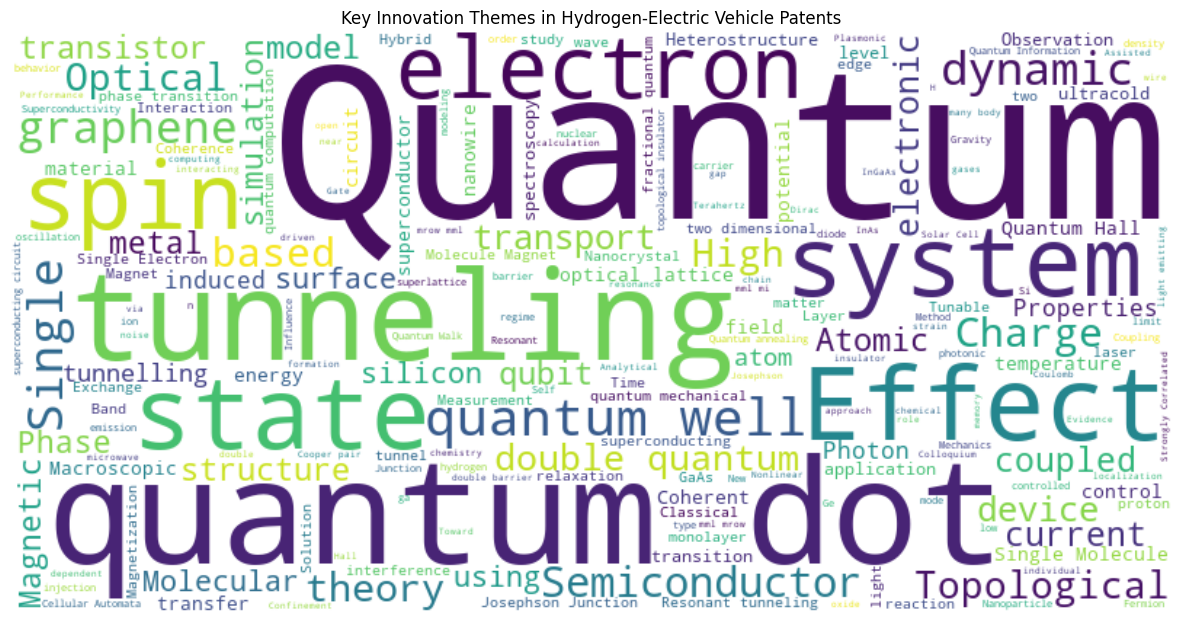

In [1727]:
# Combine all titles
text = ' '.join(final['title'].dropna().astype(str))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Key Innovation Themes in Hydrogen-Electric Vehicle Patents')
plt.show()

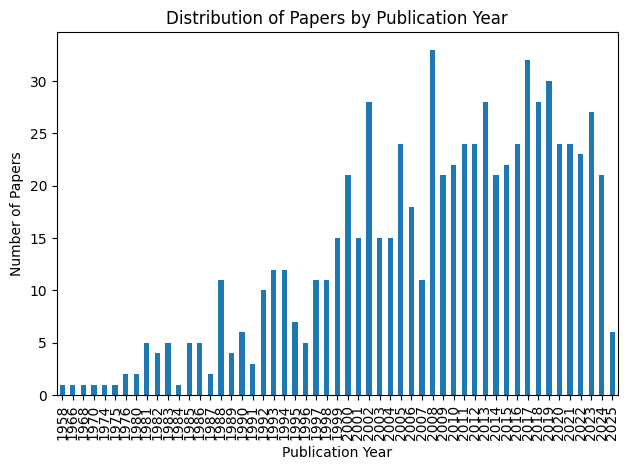

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming the DataFrame is named df
# df = pd.DataFrame({
#     'publication_year': [2020, 2021, 2020, 2019, 2021, 2022, 2020, 2019, 2022, 2021]  # example data
# })

# In real use, replace the above with:
# df = final  # or whatever the combined DataFrame variable is

# Drop missing years and convert to int
years = final['publication_year'].dropna().astype(int)

# Count occurrences per year
year_counts = years.value_counts().sort_index()

# Plot distribution
plt.figure()
year_counts.plot(kind='bar')
plt.xlabel('Publication Year')
plt.ylabel('Number of Papers')
plt.title('Distribution of Papers by Publication Year')
plt.tight_layout()
plt.show()


In [1733]:
import re

def clean_text(text):
  """
  Cleans the input text by removing special characters, extra spaces, and converting to lowercase.
  """
  if pd.isna(text):
    return None
  # Remove special characters and numbers
  text = re.sub(r'[^a-zA-Z\s]', '', text)
  # Convert to lowercase
  text = text.lower()
  # Remove extra spaces
  text = re.sub(r'\s+', ' ', text).strip()
  return text

# Apply the cleaning function to the 'title' column
final['title'] = final['title'].apply(clean_text)
# Remove stopwords and perform additional text cleaning
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Ensure stopwords are downloaded
import nltk
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

def remove_stopwords_and_clean(text):
  """
  Removes stopwords and performs additional text cleaning.
  """
  if pd.isna(text):
    return None
  # Tokenize the text
  words = word_tokenize(text)
  # Remove stopwords
  filtered_words = [word for word in words if word not in stop_words]
  # Join the words back into a single string
  return ' '.join(filtered_words)

# Apply the function to the 'title' column
final['title'] = final['title'].apply(remove_stopwords_and_clean)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tasni\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tasni\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [1734]:
import pandas as pd
from collections import defaultdict
from scipy.stats import linregress

def track_cooccurrence_trends(df: pd.DataFrame, 
                             time_col: str = 'year',
                             text_col: str = 'abstract',
                             window_size: int = 5,
                             min_count: int = 5) -> pd.DataFrame:
    """
    Track co-occurrence trends over time with statistical significance
    
    Args:
        df: DataFrame containing temporal text data
        time_col: Column name for time periods (years)
        text_col: Column name containing text to analyze
        window_size: Window size for co-occurrence detection
        min_count: Minimum total occurrences to consider
        
    Returns:
        DataFrame with co-occurrence pairs and trend metrics
    """
    # Group documents by time period
    time_groups = df.groupby(time_col)[text_col].agg(list)
    
    # Store co-occurrence frequencies by year
    temporal_counts = defaultdict(lambda: defaultdict(int))
    
    # Process each time period
    for year, documents in time_groups.items():
        year_cooc = defaultdict(int)
        
        # Process each document in the time period
        for doc in documents:
            pairs = build_cooccurrence(doc, window_size)
            for pair, count in pairs.items():
                year_cooc[pair] += count
                
        # Store annual counts
        for pair, count in year_cooc.items():
            temporal_counts[pair][year] = count
    
    # Convert to DataFrame and calculate trends
    cooc_df = pd.DataFrame.from_dict(temporal_counts, orient='index')
    
    # Calculate trend metrics
    trend_data = []
    for pair, counts in cooc_df.iterrows():
        years = counts.dropna().index.astype(int)
        freqs = counts.dropna().values
        
        if len(years) < 3 or sum(freqs) < min_count:
            continue  # Skip sparse pairs
            
        # Calculate linear regression
        slope, _, _, p_value, _ = linregress(years, freqs)
        
        trend_data.append({
            'term1': pair[0],
            'term2': pair[1],
            'slope': slope,
            'p_value': p_value,
            'total_count': sum(freqs),
            'first_year': years.min(),
            'last_year': years.max(),
            'frequency_history': list(zip(years, freqs))
        })
    
    return pd.DataFrame(trend_data)

# Example usage:
cooc_trends = track_cooccurrence_trends(
    final,
    time_col='Year',
    text_col='title',
    window_size=5,
    min_count=10
)

# Get top emerging combinations
emerging_tech = cooc_trends[
    (cooc_trends.slope > 0) &
    (cooc_trends.p_value < 0.05)
].sort_values('slope', ascending=False)

print("Top emerging technology combinations:")
print(emerging_tech[['term1', 'term2', 'slope', 'total_count']].head(5))

Top emerging technology combinations:
         term1    term2     slope  total_count
125  colloidal  quantum  0.571429         11.0
62     quantum   regime  0.240223         15.0
100    quantum    walks  0.186007         13.0
97       cells    solar  0.123324         16.0
111       dots   single  0.105754         13.0


In [1]:
import pandas as pd
from collections import defaultdict
from scipy.stats import linregress

def track_cooccurrence_trends(df: pd.DataFrame, 
                             time_col: str = 'year',
                             text_col: str = 'abstract',
                             window_size: int = 5,
                             min_count: int = 5) -> pd.DataFrame:
    """
    Track co-occurrence trends over time normalized by annual word count
    
    Args:
        df: DataFrame containing temporal text data
        time_col: Column name for time periods
        text_col: Column name containing text to analyze
        window_size: Window size for co-occurrence detection
        min_count: Minimum total co-occurrences to consider
        
    Returns:
        DataFrame with co-occurrence pairs and normalized trend metrics
    """
    # Group documents by time period
    time_groups = df.groupby(time_col)[text_col].agg(list)
    
    # Store co-occurrence counts and annual word totals
    temporal_counts = defaultdict(lambda: defaultdict(int))
    year_total_words = {}

    # Process each time period
    for year, documents in time_groups.items():
        total_words = 0
        year_cooc = defaultdict(int)
        
        # Process each document
        for doc in documents:
            words = doc.split()  # Simple whitespace tokenization
            total_words += len(words)
            pairs = build_cooccurrence(doc, window_size)
            for pair, count in pairs.items():
                year_cooc[pair] += count
                
        # Store annual data
        year_total_words[year] = total_words
        for pair, count in year_cooc.items():
            temporal_counts[pair][year] = count

    # Create DataFrame of raw counts
    cooc_df = pd.DataFrame.from_dict(temporal_counts, orient='index')

    # Calculate normalized trends
    trend_data = []
    for pair, counts in cooc_df.iterrows():
        raw_counts = counts.dropna()
        if len(raw_counts) < 3:
            continue
            
        years = raw_counts.index.astype(int)
        raw_values = raw_counts.values.astype(float)
        total_raw = raw_values.sum()
        
        if total_raw < min_count:
            continue

        # Calculate normalized frequencies
        normalized = []
        for year, raw in zip(years, raw_values):
            total_words = year_total_words.get(year, 1)  # Handle missing years
            normalized.append(raw / total_words if total_words > 0 else 0)
        
        # Calculate linear regression on normalized values
        slope, _, _, p_value, _ = linregress(years, normalized)
        
        trend_data.append({
            'term1': pair[0],
            'term2': pair[1],
            'slope': slope,
            'p_value': p_value,
            'total_count': total_raw,
            'first_year': years.min(),
            'last_year': years.max(),
            'frequency_history': list(zip(years, normalized))
        })

    return pd.DataFrame(trend_data)

# Example usage remains the same
cooc_trends = track_cooccurrence_trends(
    final,
    time_col='Year',
    text_col='title',
    window_size=5,
    min_count=10
)

# Get top emerging combinations (now using normalized trends)
emerging_tech = cooc_trends[
    (cooc_trends.slope > 0) &
    (cooc_trends.p_value < 0.05)
].sort_values('slope', ascending=False)

print("Top emerging technology combinations:")
print(emerging_tech[['term1', 'term2', 'slope', 'total_count']].head(10))

NameError: name 'final' is not defined

In [ ]:
# Select top term pairs for visualization
top_terms = emerging_tech.head(5)  # Adjust the number as needed

# Prepare data for plotting
plot_data = []
for _, row in top_terms.iterrows():
    for year, freq in row['frequency_history']:
        plot_data.append({
            'year': year,
            'frequency': freq,
            'term_pair': f"{row['term1']} & {row['term2']}"
        })

plot_df = pd.DataFrame(plot_data)

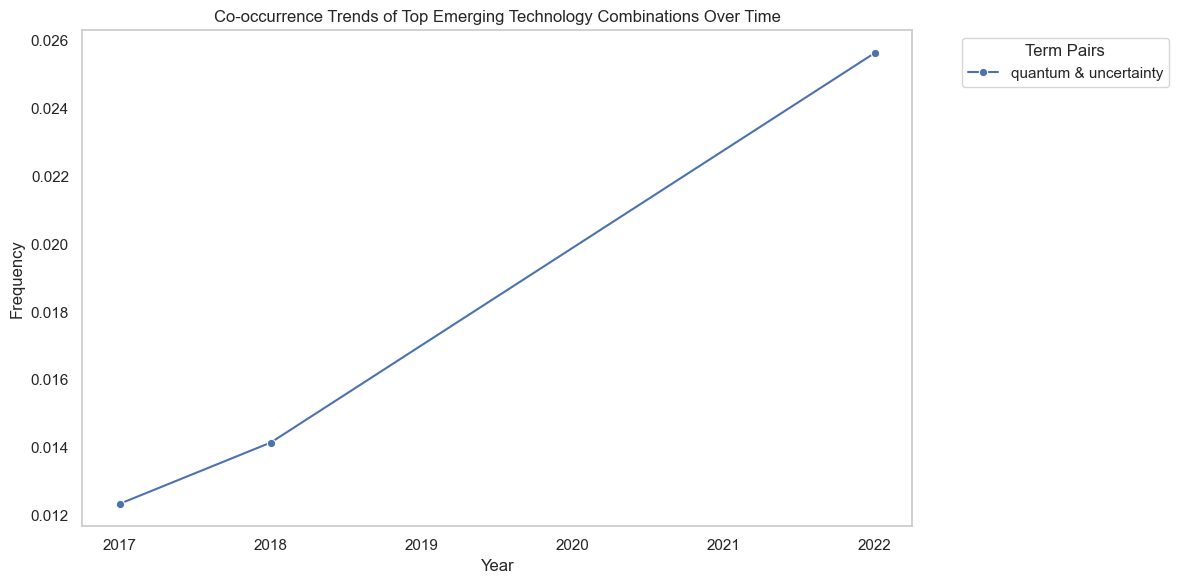

In [ ]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=plot_df, x='year', y='frequency', hue='term_pair', marker='o')
plt.title('Co-occurrence Trends of Top Emerging Technology Combinations Over Time')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.legend(title='Term Pairs', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

In [ ]:
declining_tech = cooc_trends[
    (cooc_trends.slope < 0) &
    (cooc_trends.p_value < 0.05)
].sort_values('slope')

In [ ]:
import plotly.express as px

# assume decline_plot_df is already built as in your snippet
decline_plot_data = []
for _, row in declining_tech.iterrows():
    for year, freq in row['frequency_history']:
        decline_plot_data.append({
            'year': year,
            'frequency': freq,
            'term_pair': f"{row['term1']} & {row['term2']}"
        })

decline_plot_df = pd.DataFrame(decline_plot_data)
decline_plot_df = decline_plot_df.sort_values(by='frequency', ascending=False)
decline_plot_df = decline_plot_df.head(5)  # Top 10 declining pairs
fig = px.line(
    decline_plot_df,
    x='year',
    y='frequency',
    color='term_pair',
    markers=True,
    title='Declining Co-occurrence Trends of Technology Combinations Over Time',
    labels={
        'year': 'Year',
        'frequency': 'Frequency',
        'term_pair': 'Term Pair'
    },
    hover_data={
        'term_pair': True,
        'frequency': ':.2f',    # show freq to 2 decimals
        'year': True
    }
)

# polish the layout
fig.update_layout(
    legend=dict(title='Term Pairs', orientation='v', x=1.02, y=1),
    xaxis=dict(dtick=1),       # force integer ticks if years are integers
    margin=dict(l=60, r=200, t=80, b=60),
    hovermode='x unified'      # show unified hover label
)

# if you want to highlight the decline with annotations:
for term in decline_plot_df['term_pair'].unique():
    df_sub = decline_plot_df[decline_plot_df['term_pair']==term]
    # annotate first and last point
    start = df_sub.iloc[0]
    end   = df_sub.iloc[-1]
    fig.add_annotation(
        x=end.year, y=end.frequency,
        text=f"{term}: {end.frequency:.1f}",
        showarrow=True, arrowhead=2,
        ax=20, ay=0
    )

fig.show()
